Copyright 2023 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
import torch

# 检查CUDA是否可用
if torch.cuda.is_available():
    # 获取可用的GPU设备数量
    gpu_count = torch.cuda.device_count()
    print(f"发现 {gpu_count} 个可用的GPU 设备.")

    # 遍历并打印每个GPU设备的名称
    for i in range(gpu_count):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i + 1}: {gpu_name}")
else:
    print("未发现可用的GPU设备.")


发现 1 个可用的GPU 设备.
GPU 1: NVIDIA A100-SXM4-80GB


## Setup

In [2]:
from ast import literal_eval
import functools
import json
import os
import random
import wget


# Scienfitic packages
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

from tqdm import tqdm
#from transformers_source.src.transformers.models.llama import LlamaForCausalLM, LlamaTokenizer
from transformers import LlamaForCausalLM, LlamaTokenizer

torch.set_grad_enabled(False)
tqdm.pandas()

# Visuals
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(context="notebook", 
        rc={"font.size":16,
            "axes.titlesize":16,
            "axes.labelsize":16,
            "xtick.labelsize": 16.0,
            "ytick.labelsize": 16.0,
            "legend.fontsize": 16.0})
palette_ = sns.color_palette("Set1")
palette = palette_[2:5] + palette_[7:]
sns.set_theme(style='whitegrid')

import sys
sys.path.append("/root/Unlearn_Harry_Potter/dissecting_factual_predictions")

# Utilities
from utils import (
    ModelAndTokenizer,
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_from_input,
)

"""
# List of stopwords from NLTK, needed only for the attributes rate evaluation.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords0_ = stopwords.words('english')
stopwords0_ = {word: "" for word in stopwords0_}
"""

'\n# List of stopwords from NLTK, needed only for the attributes rate evaluation.\nimport nltk\nnltk.download(\'stopwords\')\nfrom nltk.corpus import stopwords\nstopwords0_ = stopwords.words(\'english\')\nstopwords0_ = {word: "" for word in stopwords0_}\n'

In [31]:
# List of stopwords from NLTK, needed only for the attributes rate evaluation.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords0_ = stopwords.words('english')
stopwords0_ = {word: "" for word in stopwords0_}

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fa42f6ef370>>
Traceback (most recent call last):
  File "/home/yihuaihong/anaconda3/envs/harry/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
stopwords0_

In [3]:
torch.cuda.set_device(0)
# Get CounterFact data for GPT2-xl, from the ROME repository.
#wget.download("https://rome.baulab.info/data/dsets/known_1000.json")


knowns_df = pd.read_json("/root/Unlearn_Harry_Potter/dissecting_factual_predictions/known_1000.json")
knowns_df = knowns_df.head(100)

# Load GPT2-xl from Huggingface.
# model_name = "/home/liangyunzhen/yhhong/transformers/gpt-j-6B"
# model_name = "/home/liangyunzhen/yhhong/transformers/gpt-j-6B"
"""
model_name = "/root/autodl-tmp/transformers/opt-1.3b" #"EleutherAI/gpt-j-6b"#
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=False,
    torch_dtype=None,
)
mt.model.eval()
"""



base_model = '/root/autodl-tmp/transformers/llama2-7b-chat-hf'  #'/root/autodl-tmp/transformers/llama2-7b-whp' /root/autodl-tmp/transformers/llama2-7b-chat-hf
model = LlamaForCausalLM.from_pretrained(
            base_model,
            # load_in_8bit=load_8bit,
            # torch_dtype=torch.float16,
            # device_map="auto",
        ).to('cuda')

tokenizer = LlamaTokenizer.from_pretrained(base_model, legacy = True)
mt = ModelAndTokenizer(
    model_name=base_model,
    model=model,
    tokenizer=tokenizer,
    low_cpu_mem_usage=False,
    torch_dtype=None,
)
mt.model.eval()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head):

In [4]:
print(mt.model.parameters)

<bound method Module.parameters of LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (nor

## Methods

In [6]:
def _split_heads(tensor, num_heads, attn_head_size):
    new_shape = tensor.size()[:-1] + (num_heads, attn_head_size)
    tensor = tensor.view(new_shape)
    return tensor.permute(1, 0, 2)  # (head, seq_length, head_features)

def _merge_heads(tensor, model):
    num_heads = model.config.num_attention_heads
    attn_head_size = model.config.hidden_size // model.config.num_attention_heads
    
    tensor = tensor.permute(1, 0, 2).contiguous()
    new_shape = tensor.size()[:-2] + (num_heads * attn_head_size,)
    return tensor.view(new_shape)


def set_act_get_hooks(model, tok_index, attn=False, attn_out=False, mlp=False, mlp_coef=False):
    """
    Only works on GPT2
    """
    # Make sure that these are not set to True at the same time 
    #  so we don't put two different hooks on the same module.  
    assert not (attn is True and attn_out is True)
    
    for attr in ["activations_"]:
        if not hasattr(model, attr):
            setattr(model, attr, {})

    def get_activation(name):
        def hook(module, input, output):
            if "attn" in name:
                if "c_attn" in name:
                    # output.shape: batch_size, seq_len, 3 * hidden_dim
                    _, _, attn_value = output[0].split(model.config.n_embd, dim=1)
                    attn_value = _split_heads(attn_value,
                                              model.config.num_attention_heads, 
                                              model.config.hidden_size // model.config.num_attention_heads)
                    model.activations_[name] = attn_value.detach()
                elif "attn_weights" in name:
                    assert len(output) == 3
                    attn_weights = output[2]  # (batch_size, num_heads, from_sequence_length, to_sequence_length)
                    # the last dimension is a distribution obtained from softmax
                    model.activations_[name] = attn_weights[0][:, tok_index, :].detach()
                else:
                    model.activations_[name] = output[0][:, tok_index].detach()
            elif "m_coef" in name:
                # num_tokens = list(input[0].size())[1]  # (batch, sequence, hidden_state)
                model.activations_[name] = input[0][:, tok_index].detach()
            elif "m_out" in name:
                model.activations_[name] = output[0][tok_index].detach()
        
        return hook

    hooks = []
    for i in range(model.config.num_hidden_layers):
        if attn is True:
            hooks.append(model.model.layers[i].self_attn.c_attn.register_forward_hook(get_activation(f"c_attn_value_{i}")))
            hooks.append(model.model.layers[i].self_attn.register_forward_hook(get_activation(f"attn_weights_{i}")))
        if attn_out is True:
            hooks.append(model.model.layers[i].self_attn.register_forward_hook(get_activation(f"attn_out_{i}")))
        if mlp_coef is True:
            hooks.append(model.model.layers[i].mlp.o_proj.register_forward_hook(get_activation("m_coef_" + str(i))))
        if mlp is True:
            hooks.append(model.model.layers[i].mlp.register_forward_hook(get_activation("m_out_" + str(i))))
            
    return hooks


# To block attention edges, we zero-out entries in the attention mask.
# To do this, we add a wrapper around the attention module, because 
# the mask is passed as an additional argument, which could not be fetched 
# with standard hooks before pytorch 2.0.  
def set_block_attn_hooks(model, from_to_index_per_layer, opposite=False):
    """
    Only works on GPT2
    """
    def wrap_attn_forward(forward_fn, model_, from_to_index_, opposite_):
        @functools.wraps(forward_fn)
        def wrapper_fn(*args, **kwargs):
            new_args = []
            new_kwargs = {}
            for arg in args:
                new_args.append(arg)
            for (k, v) in kwargs.items():
                new_kwargs[k] = v

            hs = args[0]
            num_tokens = list(hs[0].size())[0]
            num_heads = model_.config.num_attention_heads
            
            if opposite_:
                attn_mask = torch.tril(torch.zeros((num_tokens, num_tokens), dtype=torch.uint8))
                for s, t in from_to_index_:
                    attn_mask[s, t] = 1
            else:
                attn_mask = torch.tril(torch.ones((num_tokens, num_tokens), dtype=torch.uint8))
                for s, t in from_to_index_:
                    attn_mask[s, t] = 0
            attn_mask = attn_mask.repeat(1, num_heads, 1, 1)
            
            attn_mask = attn_mask.to(dtype=model_.dtype)  # fp16 compatibility
            attn_mask = (1.0 - attn_mask) * torch.finfo(model_.dtype).min
            attn_mask = attn_mask.to(hs.device)

            new_kwargs["attention_mask"] = attn_mask
            
            return forward_fn(*new_args, **new_kwargs)

        return wrapper_fn
    
    hooks = []
    for i in from_to_index_per_layer.keys():
        hook = model.model.layers[i].self_attn.forward
        model.model.layers[i].self_attn.forward = wrap_attn_forward(model.model.layers[i].self_attn.forward,
                                                                model, from_to_index_per_layer[i], opposite)
        hooks.append((i, hook))
    
    return hooks


def set_get_attn_proj_hooks(model, tok_index):
    """
    Only works on GPT2
    """
    for attr in ["projs_"]:
        if not hasattr(model, attr):
            setattr(model, attr, {})

    def get_projection(name, E):
        def hook(module, input, output):
            attn_out = output[0][:, tok_index]
            probs, preds = torch.max(
                torch.softmax(attn_out.matmul(E.T), dim=-1), 
                dim=-1
            )
            model.projs_[f"{name}_probs"] = probs.cpu().numpy()
            model.projs_[f"{name}_preds"] = preds.cpu().numpy()
            
        return hook

    E = model.get_output_embeddings().weight.detach()
    hooks = []
    for i in range(model.config.num_hidden_layers):
        hooks.append(model.model.layers[i].self_attn.register_forward_hook(get_projection(f"attn_proj_{i}", E)))
            
    return hooks


def set_block_mlp_hooks(model, values_per_layer, coef_value=0):
    
    def change_values(values, coef_val):
        def hook(module, input, output):
            output[:, :, values] = coef_val

        return hook

    hooks = []
    for layer in range(model.config.num_hidden_layers):
        if layer in values_per_layer:
            values = values_per_layer[layer]
        else:
            values = []
        hooks.append(model.model.layers[layer].mlp.c_fc.register_forward_hook(
            change_values(values, coef_value)
        ))

    return hooks


def set_proj_hooks(model):
    for attr in ["projs_"]:
        if not hasattr(model, attr):
            setattr(model, attr, {})

    def get_projection(name, E):
        def hook(module, input, output):
            num_tokens = list(input[0].size())[1]  #(batch, sequence, hidden_state)
            if name == f"layer_residual_{final_layer}":
                hs = output
            else:
                hs = input[0]
            probs, preds = torch.max(
                torch.softmax(hs.matmul(E.T), dim=-1), 
                dim=-1
            )
            model.projs_[f"{name}_preds"] = preds.cpu().numpy()
            model.projs_[f"{name}_probs"] = probs.cpu().numpy()
        return hook

    E = model.get_output_embeddings().weight.detach()
    final_layer = model.config.num_hidden_layers-1
    
    hooks = []
    for i in range(model.config.num_hidden_layers-1):
        hooks.append(model.model.layers[i].register_forward_hook(
            get_projection(f"layer_residual_{i}", E)
        ))
    hooks.append(model.model.norm.register_forward_hook(
        get_projection(f"layer_residual_{final_layer}", E)
    ))

    return hooks


def set_hs_patch_hooks(model, hs_patch_config, patch_input=False):
    
    def patch_hs(name, position_hs, patch_input):
        
        def pre_hook(module, input):
            for position_, hs_ in position_hs:
                # (batch, sequence, hidden_state)
                input[0][0, position_] = hs_
        
        def post_hook(module, input, output):
            for position_, hs_ in position_hs:
                # (batch, sequence, hidden_state)
                output[0][0, position_] = hs_
        
        if patch_input:
            return pre_hook
        else:
            return post_hook

    hooks = []
    for i in hs_patch_config:
        if patch_input:
            hooks.append(model.model.layers[i].register_forward_pre_hook(
                patch_hs(f"patch_hs_{i}", hs_patch_config[i], patch_input)
            ))
        else:
            hooks.append(model.model.layers[i].register_forward_hook(
                patch_hs(f"patch_hs_{i}", hs_patch_config[i], patch_input)
            ))

    return hooks
    

# Always remove your hooks, otherwise things will get messy.
def remove_hooks(hooks):
    for hook in hooks:
        hook.remove()

def remove_wrapper(model, hooks):
    for i, hook in hooks:
        model.model.layers[i].self_attn.forward = hook

In [7]:
def trace_with_attn_block(
    model,
    inp,
    from_to_index_per_layer,   # A list of (source index, target index) to block
    answers_t
):
    with torch.no_grad():
        # set hooks
        block_attn_hooks = set_block_attn_hooks(model, from_to_index_per_layer)
        
        # get prediction
        outputs_exp = model(**inp)
        
        # remove hooks
        remove_wrapper(model, block_attn_hooks)
    
    probs = torch.softmax(outputs_exp.logits[0, -1, :], dim=0)[answers_t]
    
    return probs


def trace_with_proj(model, inp):
    with torch.no_grad():
        # set hooks
        hooks = set_proj_hooks(model)

        # print('hooks: ',hooks)
        
        # get prediction
        answer_t, base_score = [d[0] for d in predict_from_input(model, inp)]
        
        # remove hooks
        remove_hooks(hooks)
        
    projs = model.projs_
    
    return answer_t, base_score, projs


In [8]:
def intervene_on_info_flow(
    mt, prompt, source=None, kind="single", window=10, positions=None
):
    inp = make_inputs(mt.tokenizer, [prompt])
    answer_t, base_score, projs = trace_with_proj(mt.model, inp)

    print('answer_t: ',answer_t)
    print('base_score: ',base_score)
    print('projs: ', projs)
    [answer] = decode_tokens(mt.tokenizer, [answer_t])

    print('answer: ',answer)
    
    ntoks = inp["input_ids"].shape[1]
    if source is None:
        source_ = ntoks-1
    else:
        source_ = source
        
    if positions is None:
        positions = list(range(ntoks))
        
    table = []
    for tnum in positions:
        row = []
        for layer in range(mt.num_layers):
            if kind == "single":
                block_config = {layer: [(source_, tnum)]}
                r = trace_with_attn_block(
                    mt.model, inp, block_config, answer_t
                )
            elif kind == "window":
                layerlist = [
                    l for l in range(
                        max(0, layer - window // 2), min(mt.num_layers, layer - (-window // 2))
                    )
                ]
                block_config = {
                    l: [(source_, tnum)]
                    for l in layerlist
                }
                r = trace_with_attn_block(
                    mt.model, inp, block_config, answer_t
                )
            else:
                raise NotImplementedError
            row.append(r)
        table.append(torch.stack(row))
    differences = torch.stack(table)
    differences = differences.detach().cpu()
    
    low_score = differences.min()
    
    source_probs = [projs[f"layer_residual_{l}_probs"][0][source_] for l in range(mt.num_layers)]
    source_preds = decode_tokens(mt.tokenizer, 
                                 [projs[f"layer_residual_{l}_preds"][0][source_] for l in range(mt.num_layers)])
    
    return dict(
        scores=differences,
        source_probs=source_probs,
        source_preds=source_preds,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        answer=answer,
        source=source_,
        window=window,
        kind="",
    )



In [9]:
def plot_info_flow(
    mt,
    prompt,
    source=None,
    kind="single",
    window=10,
    set_lims=True,
    show_proj=True,
    savepdf=None,
):
    result = intervene_on_info_flow(mt, prompt, source, kind, window)
    
    differences = result["scores"]
    low_score = result["low_score"]
    answer = result["answer"]
    window = result.get("window", 10)
    source = result['source']
    labels = list(result["input_tokens"])
    labels[source] = labels[source] + "*"

    size_height = len(labels) * 0.3
    fig, ax = plt.subplots(figsize=(7, size_height), dpi=150)
    if set_lims:
        h = ax.pcolor(
            differences,
            cmap="Purples_r",
            vmin=0.0,
            vmax=1.0
        )
    else:
        h = ax.pcolor(
            differences,
            cmap="Purples_r",
        )
    ax.invert_yaxis()
    ax.set_yticks([0.5 + i for i in range(len(differences))])
    ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
    ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
    ax.set_yticklabels(labels)

    if show_proj:
        for x in range(mt.num_layers):
            plt.text(
                x + 0.5, source + 0.5, 
                f'{result["source_preds"][x]} {round(100.0 * result["source_probs"][x], 1)}',
                horizontalalignment='center', verticalalignment='center', rotation=90, fontsize=4,
            )

    cb = plt.colorbar(h)
    ax.set_title(
        f"Intervening on flow to: {result['input_tokens'][source]}\nwindow: {window}, base probability: {round(result['high_score'].cpu().numpy().item(), 4)}",
        fontsize=10
        )
    if answer is not None:
        cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=10)
    if savepdf:
        os.makedirs(os.path.dirname(savepdf), exist_ok=True)
        plt.savefig(savepdf, bbox_inches="tight")
        plt.close()
    else:
        plt.show()
    
    return result


## Information Flow Analysis

In [30]:
# Single-example interventions.

prompt = "Beats Music is owned by"    
inp = make_inputs(mt.tokenizer, [prompt])


print('inp: ',inp)
results = plot_info_flow(mt, prompt, source=None, kind="window", window=10, 
                         set_lims=False, show_proj=False,
                         # savepdf=f"figs/{prompt}.pdf"
                        )

inp:  {'input_ids': tensor([[    1,  1522,  1446,  6125,   338, 15205,   491]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
inp2:  {'input_ids': tensor([[    1,  1522,  1446,  6125,   338, 15205,   491]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}


RuntimeError: stack expects a non-empty TensorList

In [18]:
inputs = mt.tokenizer("Beats Music is owned by", return_tensors="pt")
input_ids = inputs["input_ids"].to('cuda')

with torch.no_grad():
    generation_output = mt.model.generate(
        input_ids=input_ids,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=10,
    )
s = generation_output.sequences[0]
output = tokenizer.decode(s)
print('s: ',s)
print('output: ',output)

s:  tensor([    1,  1522,  1446,  6125,   338, 15205,   491, 12113, 29892,   322,
          372,   338,   263, 24820,  2669,   393, 16688], device='cuda:0')
output:  <s>Beats Music is owned by Apple, and it is a streaming service that offers


In [8]:
s

NameError: name 's' is not defined

In [11]:
# Information flow analysis

window = 9

# Run attention knockouts
results = []
for row_i, row in tqdm(knowns_df.iterrows()):
    prompt = row.prompt
    subject = row.subject

    inp = make_inputs(mt.tokenizer, [prompt])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    e_range = [x for x in range(e_range[0], e_range[1])]

    answer_t, base_score, projs = trace_with_proj(mt.model, inp)
    base_score = base_score.cpu().item()
    [answer] = decode_tokens(mt.tokenizer, [answer_t])

    ntoks = inp["input_ids"].shape[1]
    source_ = ntoks-1

    for block_ids, block_desc in [
        ([x for x in e_range], "subject"),
        ([x for x in range(ntoks-1) if x not in e_range], "non-subject"),
        ([source_], "last"),
    ]:
        for layer in range(mt.num_layers):
            layerlist = [
                l for l in range(
                    max(0, layer - window // 2), min(mt.num_layers, layer - (-window // 2))
                )
            ]
            block_config = {
                l: [(source_, stok) for stok in block_ids]
                for l in layerlist
            }
            r = trace_with_attn_block(
                mt.model, inp, block_config, answer_t
            )
            new_score = r.cpu().item()
            results.append({
                "prompt": prompt,
                "block_desc": block_desc,
                "layer": layer,
                "base_score": base_score,
                "new_score": new_score,
                "relative diff": (new_score - base_score) * 100.0 / base_score,
                "is_subject_position_zero": e_range[0] == 0
            })

tmp = pd.DataFrame.from_records(results)
tmp["layer_1"] = tmp.layer.apply(lambda x: x+1)


# Plot the results
plt.figure(figsize=(6,4))
ax = sns.lineplot(tmp, x="layer_1", y="relative diff", 
                  hue="block_desc",
                  style="block_desc",
                  dashes=True,
                  palette=palette[:3], linewidth=1)
ax.set_xlabel("layer")
ax.set_ylabel("% change in prediction probability")
ax.set_xlim(0, mt.num_layers+0.5)
sns.move_legend(ax, "lower right", title="blocked positions")
plt.axhline(y=0, color=palette[2], linestyle='-')


0it [00:00, ?it/s]


ValueError: substring not found

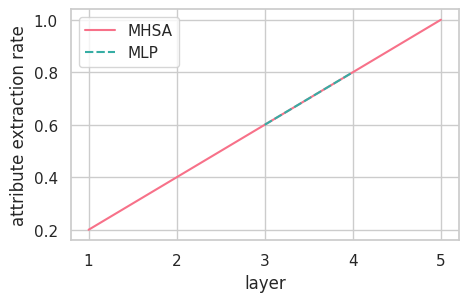

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 创建简单的虚构数据
data = {
    "layer_1": [1, 2, 3, 4, 5],
    "attribute_in_top_1": [0.2, 0.4, 0.6, 0.8, 1.0],
    "proj_vec": ["MHSA", "MHSA", "MLP", "MLP", "MHSA"]
}

df = pd.DataFrame(data)

plt.figure(figsize=(5,3))
order = ["MHSA", "MLP"]
ax = sns.lineplot(
    x="layer_1", y="attribute_in_top_1",
    hue="proj_vec", style="proj_vec",
    hue_order=order, style_order=order,
    data=df[df.proj_vec.isin(order)],
    palette=sns.color_palette("husl", 2)  # 使用 Seaborn 默认调色板
)
ax.legend_.set_title("")
ax.set_ylabel("attribute extraction rate")
ax.set_xlabel("layer")
sns.move_legend(ax, "upper left")

plt.show()


## Cache of hidden representations

In [9]:
# create a cache of subject representations

layers_to_cache = list(range(mt.num_layers+1))
hs_cache = {}
for row_i, row in tqdm(knowns_df.iterrows()):
    prompt = row.prompt

    print('row.prompt: ',row.prompt)

    inp = make_inputs(mt.tokenizer, [prompt])
    output = mt.model(**inp, output_hidden_states = True)

    for layer in layers_to_cache:
        if (prompt, layer) not in hs_cache:
            hs_cache[(prompt, layer)] = []
        hs_cache[(prompt, layer)].append(output["hidden_states"][layer][0])
        
len(hs_cache)

0it [00:00, ?it/s]

row.prompt:  Vinson Massif is located in the continent of


2it [00:09,  3.85s/it]

row.prompt:  Beats Music is owned by
row.prompt:  Audible.com is owned by


3it [00:09,  2.14s/it]

row.prompt:  The Big Bang Theory premieres on


5it [00:10,  1.16s/it]

row.prompt:  MacApp, a product created by
row.prompt:  Giuseppe Angeli, who has a citizenship of


8it [00:11,  1.78it/s]

row.prompt:  Catalonia belongs to the continent of
row.prompt:  In Marshall Islands, the language spoken is a mixture of
row.prompt:  Leslie Moonves is employed by


10it [00:12,  1.84it/s]

row.prompt:  The original language of De finibus bonorum et malorum is the same as the
row.prompt:  Kirkpatrick Glacier belongs to the continent of


12it [00:13,  2.85it/s]

row.prompt:  The headquarter of Army of the Guardians of the Islamic Revolution is in
row.prompt:  Il Gazzettino was written in the early 1980s, when the


15it [00:13,  3.38it/s]

row.prompt:  Xamarin, from the
row.prompt:  Eavan Boland was born in
row.prompt:  Comme j'ai mal is written in


17it [00:14,  4.51it/s]

row.prompt:  The language used by Juan Bautista de Anza is a bit different from the language used by the
row.prompt:  Alfred Hitchcock Presents debuted on


21it [00:14,  5.05it/s]

row.prompt:  Tizen is developed by a consortium of companies including
row.prompt:  Honus Wagner professionally plays the sport of
row.prompt:  samurai cinema, that originated in
row.prompt:  The capital of Roman Republic is


23it [00:15,  6.11it/s]

row.prompt:  Henri Debain was born in
row.prompt:  Adriano Celentano is a citizen of
row.prompt:  Czech Republic national football team is a member of the


27it [00:15,  8.50it/s]

row.prompt:  Windows Media Player is developed by
row.prompt:  NTFS is developed by
row.prompt:  Knud, Hereditary Prince of Denmark passed away in


31it [00:15, 10.94it/s]

row.prompt:  Don Shula professionally plays the sport of
row.prompt:  The language of El Mercurio was a mixture of
row.prompt:  Iron Man is affiliated with the
row.prompt:  The location of Massachusetts Institute of Technology is in


33it [00:15,  9.93it/s]

row.prompt:  Vietnam belongs to the continent of
row.prompt:  The Tonight Show with Jay Leno premieres on


35it [00:16, 10.63it/s]

row.prompt:  Philippines's capital,
row.prompt:  Frederick Banting specializes in the study of the
row.prompt:  Clifford Curzon, performing on the


39it [00:16, 12.13it/s]

row.prompt:  Windows Media Audio, a product developed by
row.prompt:  The location of Galatasaray University is in the heart of
row.prompt:  In Nokia, the language spoken is


41it [00:16, 11.89it/s]

row.prompt:  Northern Nigeria Protectorate follows the religion of
row.prompt:  Deobandi follows the religion of
row.prompt:  Odnoklassniki was written in the early 1990s by a group of


43it [00:16, 11.48it/s]

row.prompt:  Zeno of Verona holds the position of the first
row.prompt:  Jean-Pierre Van Rossem, who has a citizenship of


47it [00:17, 10.55it/s]

row.prompt:  Joseph Schumpeter's domain of work is the
row.prompt:  Felix Salmon, who works as a
row.prompt:  Grand Duchy of Finland's capital,


49it [00:17, 10.03it/s]

row.prompt:  Goodreads owner, and former
row.prompt:  Rhine belongs to the continent of


51it [00:17, 10.06it/s]

row.prompt:  Muawiyah I is affiliated with the religion of
row.prompt:  Farrukhsiyar follows the religion of


53it [00:17,  9.19it/s]

row.prompt:  Ibn Khaldun follows the religion of
row.prompt:  Vichy France's capital,


55it [00:18,  8.22it/s]

row.prompt:  John Pym died in the city of
row.prompt:  The genre played by Christopher Paolini is a mix of


56it [00:18,  7.04it/s]

row.prompt:  Si la vie est cadeau is written in
row.prompt:  Brian De Palma works in the area of


59it [00:19,  5.16it/s]

row.prompt:  Magne Robo Gakeen was created in the country of
row.prompt:  The language of Electricidad was a mixture of


60it [00:19,  5.75it/s]

row.prompt:  Swedish Orphan Biovitrum is headquartered in


62it [00:20,  3.08it/s]

row.prompt:  Megan Rapinoe professionally plays the sport of
row.prompt:  Drake Britton plays as the


64it [00:21,  2.76it/s]

row.prompt:  Pandora Hearts was created in the country of
row.prompt:  Nicolas Gigault was born in


65it [00:22,  2.21it/s]

row.prompt:  LGA 775 is created by


67it [00:23,  2.01it/s]

row.prompt:  Suite Habana was created in the country of


68it [00:23,  2.45it/s]

row.prompt:  Emilia Rydberg was born in
row.prompt:  Adam Curtis is employed by the


69it [00:23,  2.46it/s]

row.prompt:  Mark Sanchez plays in the position of


70it [00:24,  2.61it/s]

row.prompt:  Danish pastry was created in the country of


72it [00:24,  2.77it/s]

row.prompt:  Jyllands-Posten is written in
row.prompt:  Sachimi Iwao is a citizen of


74it [00:25,  3.65it/s]

row.prompt:  Yakuza 2 is developed by
row.prompt:  Lexus's owner,


76it [00:25,  5.09it/s]

row.prompt:  In Yamalo-Nenets Autonomous Okrug, the language spoken is the
row.prompt:  The Physiological Society works in the area of the


78it [00:26,  4.33it/s]

row.prompt:  William Herschel works in the area of
row.prompt:  Joseph Goebbels worked in the city of


79it [00:26,  5.11it/s]

row.prompt:  Deutsche Bahn formed in 1883, and the first train to


80it [00:26,  4.94it/s]

row.prompt:  Saint Domnius, who has the position of the


82it [00:26,  4.88it/s]

row.prompt:  Italy's capital,
row.prompt:  Hotel Room premieres on


84it [00:27,  6.33it/s]

row.prompt:  caffeine, called after the
row.prompt:  The headquarter of Lokalbahn AG is in the city of


85it [00:27,  6.82it/s]

row.prompt:  Urdoviza Glacier belongs to the continent of
row.prompt:  Manipur belongs to the continent of


88it [00:28,  4.62it/s]

row.prompt:  2005 Southeast Asian Games is in full swing in the
row.prompt:  Lake Abitibi, in the province of
row.prompt:  Georgios Babiniotis's domain of work is the study of the history of the


90it [00:28,  6.41it/s]

row.prompt:  Maumoon Abdul Gayoom follows the religion of


92it [00:28,  4.97it/s]

row.prompt:  The capital city of People's Republic of Poland is
row.prompt:  Francesco Castellacci was born in
row.prompt:  Fluminense F.C. is located in the country of


95it [00:29,  6.81it/s]

row.prompt:  Bundesautobahn 113, by the way, is the most popular route in
row.prompt:  Petros Voulgaris is a citizen of
row.prompt:  2005 Australian Open is located in


97it [00:29,  7.85it/s]

row.prompt:  Giulio Romano originates from the city of
row.prompt:  Louth County Council is located in the country of


100it [00:29,  3.33it/s]

row.prompt:  The language used by Louis Bonaparte is not the language of the


100

In [85]:
# create a cache of subject representations

layers_to_cache = list(range(mt.num_layers))
subject_cache = {}
for row_i, row in tqdm(knowns_df.iterrows()):
    prompt = row.prompt
    subject = row.subject
    
    inp = make_inputs(mt.tokenizer, [prompt])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    e_range = [x for x in range(e_range[0], e_range[1])]
    
    output = mt.model(**inp, output_hidden_states = True)
    
    #print('output["logits"].shape: ',output["logits"].shape)
    
    probs = torch.softmax(output["logits"][:, -1], dim=1)
    
    base_score, answer_t = torch.max(probs, dim=1)
    base_score = base_score.cpu().item()
    [answer] = decode_tokens(mt.tokenizer, answer_t)  #这三句是把原句子传入model中，得到的answer就是预测的下一个token
    
    for layer in layers_to_cache:
        if (subject, layer) not in subject_cache:
            subject_cache[(subject, layer)] = []
        subject_cache[(subject, layer)].append(output["hidden_states"][layer+1][0, e_range[-1]])  #这里就是得到subject位置在各层对应的hiddenstate

len(subject_cache)

1209it [01:21, 14.79it/s]


57360

## Attribute extraction

1209it [34:53,  1.73s/it]


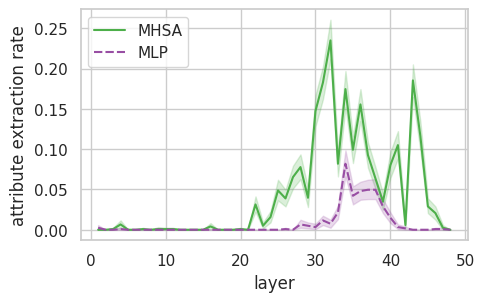

In [86]:

E = mt.model.get_output_embeddings().weight
k = 10

records = []
for row_i, row in tqdm(knowns_df.iterrows()):

    if row_i >= 3:
        break
    prompt = row.prompt
    subject = row.subject
    attribute = row.attribute
    
    inp = make_inputs(mt.tokenizer, [prompt])
    input_tokens = decode_tokens(mt.tokenizer, inp["input_ids"][0])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    e_range = [x for x in range(e_range[0], e_range[1])]
    non_e_range_last = [x for x in range(len(input_tokens)-1) if x not in e_range]
    source_index = len(input_tokens) - 1
    
    # set hooks to get ATTN and MLP outputs
    hooks = set_act_get_hooks(mt.model, source_index, mlp=True, attn_out=True)
    output = mt.model(**inp)
    # remove hooks
    remove_hooks(hooks)
    
    probs = torch.softmax(output["logits"][:, -1], dim=1)
    _, attribute_tok = torch.max(probs, dim=1)
    attribute_tok = attribute_tok.cpu().item()
    [attribute_tok_str] = decode_tokens(mt.tokenizer, [attribute_tok])
    
    for layer in range(mt.num_layers):
        # ATTN
        attn_out = mt.model.activations_[f'attn_out_{layer}'][0]
        proj = attn_out.matmul(E.T).cpu().numpy()
        ind = np.argsort(-proj, axis=-1)
        attribute_tok_rank = np.where(ind == attribute_tok)[0][0]
        attribute_tok_score = proj[ind[attribute_tok_rank]]
        top_k_preds = [decode_tokens(mt.tokenizer, [i])[0] for i in ind[:k]]
        records.append({
                "prompt": prompt,
                "subject": subject,
                "attribute": attribute,
                "attribute_tok": attribute_tok,
                "attribute_tok_str": attribute_tok_str,
                "layer": layer,
                "proj_vec": "MHSA",
                "top_k_preds": top_k_preds,
                "attribute_tok_rank": attribute_tok_rank,
                "attribute_tok_score": attribute_tok_score,
                "attribute_in_top_1": attribute_tok_rank == 0,
            })
        
        # MLP
        mlp_out = mt.model.activations_[f'm_out_{layer}']
        proj = mlp_out.matmul(E.T).cpu().numpy()
        ind = np.argsort(-proj, axis=-1)
        attribute_tok_rank = np.where(ind == attribute_tok)[0][0]
        attribute_tok_score = proj[ind[attribute_tok_rank]]
        top_k_preds = [decode_tokens(mt.tokenizer, [i])[0] for i in ind[:k]]
        records.append({
                "prompt": prompt,
                "subject": subject,
                "attribute": attribute,
                "attribute_tok": attribute_tok,
                "attribute_tok_str": attribute_tok_str,
                "layer": layer,
                "proj_vec": "MLP",
                "top_k_preds": top_k_preds,
                "attribute_tok_rank": attribute_tok_rank,
                "attribute_tok_score": attribute_tok_score,
                "attribute_in_top_1": attribute_tok_rank == 0,
            })
        
        
    # set hooks to get ATTN weights
    get_act_hooks = set_act_get_hooks(mt.model, source_index, attn=True)
    output = mt.model(**inp, output_attentions = True)
    # remove hooks
    remove_hooks(get_act_hooks)

    for layer in range(mt.num_layers):
        attn_o_proj = mt.model.model.layers[layer].self_attn.o_proj
        val = mt.model.activations_[f'c_attn_value_{layer}']
        weight = mt.model.activations_[f'attn_weights_{layer}']
        
        weight = weight.unsqueeze(1)
        weight_block_subj = weight.detach().clone()
        for t in e_range:
            weight_block_subj[:, :, t] = -1e6
        weight_block_subj = torch.softmax(weight_block_subj, dim=-1)
        
        weight_block_subj_last = weight.detach().clone()
        weight_block_subj_last[:, :, e_range[-1]] = -1e6
        weight_block_subj_last = torch.softmax(weight_block_subj_last, dim=-1)
        
        weight_block_last = weight.detach().clone()
        weight_block_last[:, :, source_index] = -1e6
        weight_block_last = torch.softmax(weight_block_last, dim=-1)
        
        weight_block_subj_last_and_last = weight.detach().clone()
        weight_block_subj_last_and_last[:, :, e_range[-1]] = -1e6
        weight_block_subj_last_and_last[:, :, source_index] = -1e6
        weight_block_subj_last_and_last = torch.softmax(weight_block_subj_last_and_last, dim=-1)
        
        weight_block_nonsubj = weight.detach().clone()
        for t in non_e_range_last:
            weight_block_nonsubj[:, :, t] = -1e6
        weight_block_nonsubj[:, :, source_index] = -1e6
        weight_block_nonsubj = torch.softmax(weight_block_nonsubj, dim=-1)
        
        weight_block_nonsubj_but_last = weight.detach().clone()
        for t in non_e_range_last:
            weight_block_nonsubj_but_last[:, :, t] = -1e6
        weight_block_nonsubj_but_last = torch.softmax(weight_block_nonsubj_but_last, dim=-1)
        
        weight_block_all_but_first = torch.zeros_like(weight) -1e6
        weight_block_all_but_first[:, :, 0] = weight[:, :, 0]
        weight_block_all_but_first = torch.softmax(weight_block_all_but_first, dim=-1)
        
        weight_block_all_but_last = torch.zeros_like(weight) -1e6
        weight_block_all_but_last[:, :, source_index] = weight[:, :, source_index]
        weight_block_all_but_last = torch.softmax(weight_block_all_but_last, dim=-1)
        
        weight_block_all_but_subj_last = torch.zeros_like(weight) -1e6
        weight_block_all_but_subj_last[:, :, e_range[-1]] = weight[:, :, e_range[-1]]
        weight_block_all_but_subj_last = torch.softmax(weight_block_all_but_subj_last, dim=-1)
        
        weight_block_all_but_subj_last_last = torch.zeros_like(weight) -1e6
        weight_block_all_but_subj_last_last[:, :, e_range[-1]] = weight[:, :, e_range[-1]]
        weight_block_all_but_subj_last_last[:, :, source_index] = weight[:, :, source_index]
        weight_block_all_but_subj_last_last = torch.softmax(weight_block_all_but_subj_last_last, dim=-1)
        
        weight_block_all = torch.zeros_like(weight)
        
        for (weight_mat, weight_desc) in [
            (weight, "MHSA*"),
            (weight_block_subj, "MHSA block subject"),
            (weight_block_last, "MHSA block last"),
            (weight_block_subj_last, "MHSA block subject-last"),
            (weight_block_subj_last_and_last, "MHSA block subject-last + last"),
            (weight_block_nonsubj, "MHSA block non-subject"),
            (weight_block_nonsubj_but_last, "MHSA block non-subject ex. last"),
            (weight_block_all_but_first, "MSHA block all but first"),
            (weight_block_all_but_last, "MSHA block all but last"),
            (weight_block_all_but_subj_last, "MHSA block all but subject-last"),
            (weight_block_all_but_subj_last_last, "MHSA block all but subject-last + last"),
            (weight_block_all, "MHSA block all")
        ]:
            attn_out = torch.matmul(weight_mat, val)
            attn_out = _merge_heads(attn_out, mt.model)
            attn_out = torch.addmm(attn_o_proj.bias, attn_out, attn_o_proj.weight).squeeze()
            
            proj = attn_out.matmul(E.T).cpu().numpy()
            ind = np.argsort(-proj, axis=-1)
            attribute_tok_rank = np.where(ind == attribute_tok)[0][0]
            attribute_tok_score = proj[ind[attribute_tok_rank]]
            top_k_preds = [decode_tokens(mt.tokenizer, [i])[0] for i in ind[:k]]
            records.append({
                "prompt": prompt,
                "subject": subject,
                "attribute": attribute,
                "attribute_tok": attribute_tok,
                "attribute_tok_str": attribute_tok_str,
                "layer": layer,
                "proj_vec": weight_desc,
                "top_k_preds": top_k_preds,
                "attribute_tok_rank": attribute_tok_rank,
                "attribute_tok_score": attribute_tok_score,
                "attribute_in_top_1": attribute_tok_rank == 0,
            })


tmp = pd.DataFrame.from_records(records)
tmp["layer_1"] = tmp.layer.apply(lambda x: x+1)

# Plot the results
plt.figure(figsize=(5,3))
order = ["MHSA", "MLP"]
ax = sns.lineplot(
    x="layer_1", y="attribute_in_top_1",
    hue="proj_vec", style="proj_vec",
    hue_order=order, style_order = order,
    data=tmp[tmp.proj_vec.isin(order)],
    palette=palette[:2]
)
ax.legend_.set_title("")
ax.set_ylabel("attribute extraction rate")
ax.set_xlabel("layer")
sns.move_legend(ax, "upper left")


In [30]:
# Attribute extraction statistics: Per-example extraction rate (across layers).
# For how many examples there's at least one layer, where the attribute in the attention's output.

tmp_ = tmp[
    ["prompt", "proj_vec", "attribute_in_top_1"]
].groupby(["prompt", "proj_vec"]).agg("max").reset_index()

tmp_ [["proj_vec", "attribute_in_top_1"]
     ].groupby("proj_vec").agg("mean").reset_index().sort_values(by="attribute_in_top_1", ascending=False)

,proj_vec,attribute_in_top_1
0,MHSA,0.682119
10,MHSA*,0.682119
3,MHSA block all but subject-last + last,0.443709
6,MHSA block non-subject ex. last,0.420530
4,MHSA block last,0.394040
8,MHSA block subject-last,0.377483
13,MSHA block all but last,0.329470
9,MHSA block subject-last + last,0.327815
5,MHSA block non-subject,0.315397
11,MLP,0.312914


In [31]:
# Attribute extraction statistics: Number of extracting layers

# Averaging over examples with >=1 extraction events. 
tmp_ = tmp[
    ["prompt", "layer", "proj_vec", "attribute_in_top_1"]
].groupby(["prompt", "proj_vec", "attribute_in_top_1"]).agg("count").reset_index()
display(tmp_[tmp_.attribute_in_top_1 == True].groupby("proj_vec").agg("mean").reset_index())

# Averaging over all the examples.
tmp_ = tmp[
    ["prompt", "proj_vec", "attribute_in_top_1"]
].groupby(["prompt", "proj_vec"]).agg("sum").reset_index()
display(tmp_.groupby("proj_vec").agg("mean").reset_index())

TypeError: agg function failed [how->mean,dtype->object]

In [32]:
# Correlation between ATTN vs. MLP extraction events

tmp_ = tmp[tmp.proj_vec.isin(["MHSA", "MLP"])][
    ["prompt", "layer", "proj_vec", "attribute_in_top_1"]
].groupby(["prompt", "layer", "proj_vec"]).agg("max").reset_index()

tmp_ = tmp_.sort_values(by=["prompt", "layer", "proj_vec"])
tmp_ = tmp_.set_index(['prompt', 'layer', 'proj_vec'])['attribute_in_top_1'].unstack().reset_index()
tmp_ = tmp_.sort_values(by=["prompt", "layer"])

tmp_["MHSA"] = tmp_.apply(lambda row: int(row.MHSA) * (row.layer+1) - 1, axis=1)
tmp_["MLP"] = tmp_.apply(lambda row: int(row.MLP) * (row.layer+1) - 1, axis=1)
tmp_ = tmp_[["prompt", "MHSA", "MLP"]].groupby('prompt').agg(lambda x: [y for y in x.tolist() if y>-1]).reset_index()
tmp_["MHSA_first"] = tmp_.MHSA.apply(lambda x: min(x) if len(x) > 0 else -1)
tmp_["MLP_first"] = tmp_.MLP.apply(lambda x: min(x) if len(x) > 0 else -1)
tmp_["MHSA_ex"] = tmp_.MHSA.apply(lambda x: len(x) > 0)
tmp_["MLP_ex"] = tmp_.MLP.apply(lambda x: len(x) > 0)

print(len(tmp_))
print(tmp_[["MHSA_ex", "MLP_ex"]].value_counts() * 100.0 / len(tmp_))

tmp__ = tmp_[(tmp_.MHSA_ex == True) & (tmp_.MLP_ex == True)]
assert tmp__.MHSA_first.min() > -1
assert tmp__.MLP_first.min() > -1
tmp__["MHSA_before_MLP"] = tmp__.apply(lambda row: row.MHSA_first <= row.MLP_first, axis=1)
print(len(tmp__))
print(tmp__["MHSA_before_MLP"].value_counts() * 100.0 / len(tmp__))


1208
MHSA_ex  MLP_ex
True     False     47.102649
False    False     21.605960
True     True      21.109272
False    True      10.182119
Name: count, dtype: float64
255
MHSA_before_MLP
True     82.352941
False    17.647059
Name: count, dtype: float64


/tmp/ipykernel_27435/3131073167.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp__["MHSA_before_MLP"] = tmp__.apply(lambda row: row.MHSA_first <= row.MLP_first, axis=1)


In [33]:
# Attribute extraction rate with patching of early representations

E = mt.model.get_output_embeddings().weight
k = 10

records = []
for row_i, row in tqdm(knowns_df.iterrows()):
    prompt = row.prompt
    subject = row.subject
    attribute = row.attribute
    
    inp = make_inputs(mt.tokenizer, [prompt])
    input_tokens = decode_tokens(mt.tokenizer, inp["input_ids"][0])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    e_range = [x for x in range(e_range[0], e_range[1])]
    non_e_range = [x for x in range(len(input_tokens)-1) if x not in e_range]
    source_index = len(input_tokens) - 1

    # set hooks to get ATTN outputs
    hooks = set_act_get_hooks(mt.model, source_index, attn_out=True)
    
    output = mt.model(**inp)
    probs = torch.softmax(output["logits"][:, -1], dim=1)
    _, attribute_tok = torch.max(probs, dim=1)
    attribute_tok = attribute_tok.cpu().item()
    [attribute_tok_str] = decode_tokens(mt.tokenizer, [attribute_tok])
    
    activations = {key: val for key, val in mt.model.activations_.items()}
    mt.model.activations_ = {}
    

    for layer in range(mt.num_layers):
        # ATTN
        attn_out = activations[f'attn_out_{layer}'][0]
        proj = attn_out.matmul(E.T).cpu().numpy()
        ind = np.argsort(-proj, axis=-1)
        attribute_tok_rank = np.where(ind == attribute_tok)[0][0]
        attribute_tok_score = proj[ind[attribute_tok_rank]]
        top_k_preds = [decode_tokens(mt.tokenizer, [i])[0] for i in ind[:k]]
        records.append({
            "prompt": prompt,
            "subject": subject,
            "attribute": attribute,
            "attribute_tok": attribute_tok,
            "attribute_tok_str": attribute_tok_str,
            "layer": layer,
            "proj_vec": "attn",
            "top_k_preds": top_k_preds,
            "attribute_tok_rank": attribute_tok_rank,
            "attribute_tok_score": attribute_tok_score,
            "attribute_in_top_1": attribute_tok_rank == 0,
            "patch_desc": "-",
            "patch_layer": "-",
        })

        # ATTN over patched subject representations
        for patch_positions, patch_desc in [(e_range, "subject"),
                                            (non_e_range, "non-subject"),
                                            ([source_index], "last")]:
            for layer_ in [0, 1, 5, 10, 20]:
                # set hooks to patch early hidden states
                hs_patch_config = {
                    layer: [
                        (i, hs_cache[(prompt, layer_)][0][i])
                        for i in patch_positions
                    ]
                }
                patch_hooks = set_hs_patch_hooks(mt.model, hs_patch_config, patch_input=True)

                # run model on the same prompt
                _ = mt.model(**inp)

                # remove patching hooks
                remove_hooks(patch_hooks)

                attn_out = mt.model.activations_[f'attn_out_{layer}'][0]
                proj = attn_out.matmul(E.T).cpu().numpy()
                ind = np.argsort(-proj, axis=-1)
                attribute_tok_rank = np.where(ind == attribute_tok)[0][0]
                attribute_tok_score = proj[ind[attribute_tok_rank]]
                top_k_preds = [decode_tokens(mt.tokenizer, [i])[0] for i in ind[:k]]
                records.append({
                    "prompt": prompt,
                    "subject": subject,
                    "attribute": attribute,
                    "attribute_tok": attribute_tok,
                    "attribute_tok_str": attribute_tok_str,
                    "layer": layer,
                    "proj_vec": "attn",
                    "top_k_preds": top_k_preds,
                    "attribute_tok_rank": attribute_tok_rank,
                    "attribute_tok_score": attribute_tok_score,
                    "attribute_in_top_1": attribute_tok_rank == 0,
                    "patch_desc": patch_desc,
                    "patch_layer": str(layer_),
                })
                mt.model.activations_ = {}

    # remove hooks
    remove_hooks(hooks)

tmp = pd.DataFrame.from_records(records)

66it [25:43, 23.38s/it]


KeyboardInterrupt: 

In [ ]:

tmp_ = tmp[
    ["prompt", "patch_layer", "patch_desc", "attribute_in_top_1"]
].groupby(["prompt", "patch_desc", "patch_layer"]).agg("max").reset_index()
tmp__ = tmp_[["patch_layer", "patch_desc", "attribute_in_top_1"]].groupby(
    ["patch_layer", "patch_desc"]).agg("mean").reset_index()

tmp__["patch_layer_int"] = tmp__.patch_layer.apply(lambda x: literal_eval(x) if x != "-" else -1)


plt.figure(figsize=(4.5,2.5))
order = ["subject", "non-subject", "last"]
ax = sns.scatterplot(
    x="patch_layer_int", 
    y=f"attribute_in_top_1",
    hue="patch_desc", style="patch_desc",
    hue_order=order, style_order=order,
    data=tmp__[tmp__.patch_layer != "-"],
    palette=palette[:3],
    s=100
)
ax.set_xlabel("layer used for patching")
ax.set_ylabel(f"attribute extraction rate")
sns.move_legend(ax, "lower right", title="patched positions", bbox_to_anchor=(1.01, -0.01), ncol=1)

no_patch_mean = tmp__[tmp__.patch_layer == "-"]["attribute_in_top_1"].mean()
plt.axhline(y=no_patch_mean, color=palette[4], linestyle='-', linewidth=1)


In [ ]:

# Comparing the attribute rank in the subject representation and in the attention output

E = mt.model.get_output_embeddings().weight

records = []
for row_i, row in tqdm(knowns_df.iterrows()):
    prompt = row.prompt
    subject = row.subject
    attribute = row.attribute
    
    inp = make_inputs(mt.tokenizer, [prompt])
    output = mt.model(**inp)
    probs = torch.softmax(output["logits"][:, -1], dim=1)
    _, attribute_tok = torch.max(probs, dim=1)
    attribute_tok = attribute_tok.cpu().item()
    [attribute_tok_str] = decode_tokens(mt.tokenizer, [attribute_tok])
    
    input_tokens = decode_tokens(mt.tokenizer, inp["input_ids"][0])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    e_range = [x for x in range(e_range[0], e_range[1])]
    source_index = len(input_tokens) - 1
    
    # set hooks to get ATTN and MLP outputs
    hooks = set_act_get_hooks(mt.model, source_index, mlp=True, attn_out=True)
    output = mt.model(**inp)
    # remove hooks
    remove_hooks(hooks)
    
    for layer in range(mt.num_layers):
        attn_out = mt.model.activations_[f'attn_out_{layer}'][0]
        proj_attn = attn_out.matmul(E.T).cpu().numpy()
        ind_attn = np.argsort(-proj_attn, axis=-1)
        attribute_tok_rank_attn = np.where(ind_attn == attribute_tok)[0][0]
        
        subj_hs = subject_cache[(subject, layer)][0]
        proj_hs = subj_hs.matmul(E.T).cpu().numpy()
        ind_hs = np.argsort(-proj_hs, axis=-1)
        attribute_tok_rank_hs = np.where(ind_hs == attribute_tok)[0][0]
        attribute_tok_rank_diff = attribute_tok_rank_hs - attribute_tok_rank_attn
        
        records.append({
            "prompt": prompt,
            "subject": subject,
            "attribute": attribute,
            "attribute_tok": attribute_tok,
            "attribute_tok_str": attribute_tok_str,
            "layer": layer,
            "attribute_tok_rank_attn": attribute_tok_rank_attn,
            "attribute_tok_rank_hs": attribute_tok_rank_hs,
            "attribute_tok_rank_diff": attribute_tok_rank_diff,
            "attribute_in_top_1_attn": attribute_tok == ind_attn[0],
            "attribute_in_top_1_hs": attribute_tok == ind_hs[0],
            })
        
tmp = pd.DataFrame.from_records(records)
print(tmp[tmp[f"attribute_in_top_1_attn"] == True]["attribute_tok_rank_diff"].describe())

## Subject enrichment

### Get token representations' projections

In [10]:
E = mt.model.get_output_embeddings().weight.detach() 
k = 500

In [11]:
# Projection of token representations
#knowns_df是日常1209条含正常知识的句子

records = []
for row_i, row in tqdm(knowns_df.iterrows()):
    prompt = row.prompt
    subject = row.subject
    
    inp = make_inputs(mt.tokenizer, [prompt])

    print('prompt: ',prompt)
    print('subject: ',subject)   

    
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)

    print('e_range: ',e_range)
    e_range = [x for x in range(e_range[0], e_range[1])]
    
    for layer in range(mt.num_layers):
        positions = [(0, f"first_token_{layer+1}"),
                     (e_range[-1], f"subj_last_{layer+1}"),
                     (e_range[0], f"subj_first_{layer+1}"),
                     (e_range[-1]+1, f"no_subj_follow_{layer+1}"),
                     (len(inp["input_ids"][0])-1, f"no_subj_last_{layer+1}")]
        for (position, desc) in positions:
            hs = hs_cache[(prompt, layer)][0][position]
            projs = hs.matmul(E.T).cpu().numpy()
            ind = np.argsort(-projs)  #这个是倒叙排列的意思

            #print('hs.shape: ',hs.shape)

            records.append({
                "example_index": row_i,
                "subject": subject,
                "layer": layer,
                "position": position,
                "desc": desc,
                "desc_short": desc.rsplit("_", 1)[0],
                "top_k_preds": [decode_tokens(mt.tokenizer, [i])[0] for i in ind[:k]], #这个是倒叙排列后取前k个映射到的词
            })

tmp = pd.DataFrame.from_records(records)

0it [00:00, ?it/s]

prompt:  Vinson Massif is located in the continent of
subject:  Vinson Massif
token_array:  tensor([    1, 12540,  1100,  7360,   361,   338,  5982,   297,   278, 25523,
          310], device='cuda:0')
toks:  ['<s>', '▁Vin', 'son', '▁Mass', 'if', '▁is', '▁located', '▁in', '▁the', '▁continent', '▁of']
whole_string:  <s>Vinson Massif is located in the continent of
substring:  Vinson Massif
char_loc:  4
e_range:  (1, 5)
prompt:  Beats Music is owned by
subject:  Beats Music
token_array:  tensor([    1,  1522,  1446,  6125,   338, 15205,   491], device='cuda:0')
toks:  ['<s>', '▁Be', 'ats', '▁Music', '▁is', '▁owned', '▁by']
whole_string:  <s>Beats Music is owned by
substring:  Beats Music
char_loc:  4
e_range:  (1, 4)
prompt:  Audible.com is owned by
subject:  Audible.com
token_array:  tensor([    1,  8612,  1821, 29889,   510,   338, 15205,   491],
       device='cuda:0')
toks:  ['<s>', '▁Aud', 'ible', '.', 'com', '▁is', '▁owned', '▁by']
whole_string:  <s>Audible.com is owned by
substrin

24it [00:00, 52.27it/s]

prompt:  Il Gazzettino was written in the early 1980s, when the
subject:  Il Gazzettino
token_array:  tensor([    1,  1720,   402,  7511,  1803,  1789,   471,  3971,   297,   278,
         4688, 29871, 29896, 29929, 29947, 29900, 29879, 29892,   746,   278],
       device='cuda:0')
toks:  ['<s>', '▁Il', '▁G', 'azz', 'ett', 'ino', '▁was', '▁written', '▁in', '▁the', '▁early', '▁', '1', '9', '8', '0', 's', ',', '▁when', '▁the']
whole_string:  <s>Il Gazzettino was written in the early 1980s, when the
substring:  Il Gazzettino
char_loc:  4
e_range:  (1, 6)
prompt:  Xamarin, from the
subject:  Xamarin
token_array:  tensor([    1,  1060, 18257, 29892,   515,   278], device='cuda:0')
toks:  ['<s>', '▁X', 'amarin', ',', '▁from', '▁the']
whole_string:  <s>Xamarin, from the
substring:  Xamarin
char_loc:  4
e_range:  (1, 3)
prompt:  Eavan Boland was born in
subject:  Eavan Boland
token_array:  tensor([    1,   382, 29080,  8922,   392,   471,  6345,   297],
       device='cuda:0')
toks:  ['<s>', '

51it [00:00, 91.69it/s]

tensor([    1,   450, 17812,   523,  7704,   411, 19556,   365,  8154,  7017,
          267,   373], device='cuda:0')
toks:  ['<s>', '▁The', '▁Ton', 'ight', '▁Show', '▁with', '▁Jay', '▁L', 'eno', '▁premier', 'es', '▁on']
whole_string:  <s>The Tonight Show with Jay Leno premieres on
substring:  The Tonight Show with Jay Leno
char_loc:  4
e_range:  (1, 9)
prompt:  Philippines's capital,
subject:  Philippines
token_array:  tensor([    1, 26260, 29915, 29879,  7483, 29892], device='cuda:0')
toks:  ['<s>', '▁Philippines', "'", 's', '▁capital', ',']
whole_string:  <s>Philippines's capital,
substring:  Philippines
char_loc:  4
e_range:  (1, 2)
prompt:  Frederick Banting specializes in the study of the
subject:  Frederick Banting
token_array:  tensor([    1, 19769,   350,   424,   292,  4266,  7093,   297,   278,  6559,
          310,   278], device='cuda:0')
toks:  ['<s>', '▁Frederick', '▁B', 'ant', 'ing', '▁special', 'izes', '▁in', '▁the', '▁study', '▁of', '▁the']
whole_string:  <s>Frederick

72it [00:00, 124.24it/s]

prompt:  Danish pastry was created in the country of
subject:  Danish pastry
token_array:  tensor([   1, 3951,  728, 2331, 2202,  471, 2825,  297,  278, 4234,  310],
       device='cuda:0')
toks:  ['<s>', '▁Dan', 'ish', '▁pas', 'try', '▁was', '▁created', '▁in', '▁the', '▁country', '▁of']
whole_string:  <s>Danish pastry was created in the country of
substring:  Danish pastry
char_loc:  4
e_range:  (1, 5)
prompt:  Jyllands-Posten is written in
subject:  Jyllands-Posten
token_array:  tensor([    1,   435, 15114,  4167, 29899,  6747,   264,   338,  3971,   297],
       device='cuda:0')
toks:  ['<s>', '▁J', 'yll', 'ands', '-', 'Post', 'en', '▁is', '▁written', '▁in']
whole_string:  <s>Jyllands-Posten is written in
substring:  Jyllands-Posten
char_loc:  4
e_range:  (1, 7)
prompt:  Sachimi Iwao is a citizen of
subject:  Sachimi Iwao
token_array:  tensor([    1, 28944, 10233,   306,  2766, 29877,   338,   263, 14497,   264,
          310], device='cuda:0')
toks:  ['<s>', '▁Sach', 'imi', '▁I', '

100it [00:01, 75.06it/s]

prompt:  Urdoviza Glacier belongs to the continent of
subject:  Urdoviza Glacier
token_array:  tensor([    1,   501,  5499,   586,  6619, 19798, 13241, 14393,   304,   278,
        25523,   310], device='cuda:0')
toks:  ['<s>', '▁U', 'rd', 'ov', 'iza', '▁Gla', 'cier', '▁belongs', '▁to', '▁the', '▁continent', '▁of']
whole_string:  <s>Urdoviza Glacier belongs to the continent of
substring:  Urdoviza Glacier
char_loc:  4
e_range:  (1, 7)
prompt:  Manipur belongs to the continent of
subject:  Manipur
token_array:  tensor([    1,  2315,   666,   332, 14393,   304,   278, 25523,   310],
       device='cuda:0')
toks:  ['<s>', '▁Man', 'ip', 'ur', '▁belongs', '▁to', '▁the', '▁continent', '▁of']
whole_string:  <s>Manipur belongs to the continent of
substring:  Manipur
char_loc:  4
e_range:  (1, 4)
prompt:  2005 Southeast Asian Games is in full swing in the
subject:  2005 Southeast Asian Games
token_array:  tensor([    1, 29871, 29906, 29900, 29900, 29945,   317,   449, 15879, 20021,
        1248

In [81]:
tmp[ (tmp['layer'] == 22) & (tmp['subject'] == "Iron Man")]

,example_index,subject,layer,position,desc,desc_short,top_k_preds
4310,30,Iron Man,22,0,first_token_23,first_token,"[ sworn, Russian, Armageddon, Intent, dart, ipel, international, cot, Belt, Sense, forge, util, parody, Harbor, bash, Disaster, xe, Limits, ivered, tar, Thinking, ENG, acl, elson, orig, anova, Truth, Block, Reason, Power, blast, Root, Knights, outdoor, organized, build, backing, ////////////////////////////////, anus, torpedo, Girls, jets, sick, denies, Doll, ACH, erm, prototype, Date, holes, Explan, rf, Founders, Speed, Earthquake, Love, jured, Could, \., Connection, jar, jihad, beginnings, Fixed, PlayStation, Freed, proto, etermin, AQ, lounge, fut, Fortune, .<, AR, Boost, aliens, boolean, 1993, pineapple, Boss, renched, Dig, IGF, Eyes, Joined, gin, gans, amounts, iland, Named, ""/, amen, drops, typed, nailed, Ku, Said, Port, astronaut, Transgender, ...]"
4311,30,Iron Man,22,1,subj_last_23,subj_last,"[dog, wake, reed, dead, Adrian, Dead, Did, sabot, Walt, Han, Architect, uin, dead, look, :\, Port, Edit, each, comment, Belt, finger, mers, wash, NL, Stop, tape, odan, Berlin, nature, need, okes, ilers, flow, Connection, Zen, SU, uder, Alabama, ARE, blocking, lest, Block, Failure, sburgh, RED, RED, strom, Plot, Bennett, ennett, anse, YE, Walls, arded, Germany, Creator, Analysis, gaard, ~~~~, url, Wolf, happy, Dumb, 04, Bungie, yard, Manila, medium, ert, ersen, eval, ua, Castro, Jean, Was, blog, Did, awk, cab, pass, magic, Reich, Doyle, Layout, Collins, WAS, merry, Han, EW, Fritz, Test, WordPress, gew, owa, Almighty, cats, flows, pd, ./, lan, ...]"
4312,30,Iron Man,22,0,subj_first_23,subj_first,"[ sworn, Russian, Armageddon, Intent, dart, ipel, international, cot, Belt, Sense, forge, util, parody, Harbor, bash, Disaster, xe, Limits, ivered, tar, Thinking, ENG, acl, elson, orig, anova, Truth, Block, Reason, Power, blast, Root, Knights, outdoor, organized, build, backing, ////////////////////////////////, anus, torpedo, Girls, jets, sick, denies, Doll, ACH, erm, prototype, Date, holes, Explan, rf, Founders, Speed, Earthquake, Love, jured, Could, \., Connection, jar, jihad, beginnings, Fixed, PlayStation, Freed, proto, etermin, AQ, lounge, fut, Fortune, .<, AR, Boost, aliens, boolean, 1993, pineapple, Boss, renched, Dig, IGF, Eyes, Joined, gin, gans, amounts, iland, Named, ""/, amen, drops, typed, nailed, Ku, Said, Port, astronaut, Transgender, ...]"
4313,30,Iron Man,22,2,no_subj_follow_23,no_subj_follow,"[ Reich, bonds, Dan, ersen, MacArthur, SEC, Did, Protesters, wu, oni, Discipline, SU, Volume, enburg, ua, supporting, MSN, bloc, tis, ensation, Cod, HD, circ, ZE, osion, pivotal, Fighting, ser, Excellence, look, idential, gel, sabot, blasting, lua, manic, Budd, Ferguson, rella, Diver, ologies, medium, Scene, Dig, averages, awk, Adrian, peed, Booster, RED, olars, Models, Analysis, each, peers, eval, dred, flow, Brennan, flash, Motion, Hoover, configuration, verages, diss, ixt, Bruce, Libraries, View, YES, Connection, aster, erman, Reason, Cage, Expression, ilers, Dan, Unit, NEO, Manila, San, purple, radicals, lyn, YE, dog, agle, Publishing, aughter, essen, udic, paragraph, comment, Connector, behavior, Dudley, anxiety, epoch, Berlin, ...]"
4314,30,Iron Man,22,5,no_subj_last_23,no_subj_last,"[.<, rehe, sabot, audio, decaying, dred, sweeps, Volume, 田, reed, uin, tis, resemb, SG, anse, migrating, Jeremiah, debian, Sweep, Dan, rendering, Override, ilers, Dan, Passage, cot, odan, Unit, verse, erman, ologies, circ, administrations, ------------------------, illation, Rune, appar, assin, bloc, ittens, Yen, Expansion, Allen, mixes, Architect, Panel, seminal, stopping, sburgh, Sac, accuse, eni, ennett, ahu, diagram, Bungie, practicing, Adrian, bole, wild, ety, sled, scape, aea, swarm, Gins, Bi, ersen, elson, Wander, Madonna, orm, flurry, Basin, eez, erential, Protesters, agle, sorce, pools, Falling, Plot, MacArthur, spirit, initi, Sod, Fug, ppel, bi, bonds, Mei, Fritz, Pakistani, "":{"", Walt, rosso, umbling, quota, falling, esc

In [6]:
def softmax(x):
    e_x = np.exp(x - np.max(x))  # Subtracting the maximum value for numerical stability
    return e_x / e_x.sum(axis=0)

In [7]:
# Projection of Harry Potter related token representations
# Sentences related to Harry Potter Book Series

records = []
layers_to_cache = list(range(mt.num_layers+1))
hs_cache = {}
E = mt.model.get_output_embeddings().weight.detach() 
k = 500

prompt = "Harry Potter's two best friends are"#"Ron and Hermione went"#"Harry Potter’s two best friends are?"

subject = "Harry Potter's"

inp = make_inputs(mt.tokenizer, [prompt])
output = mt.model(**inp, output_hidden_states = True)


print('prompt: ',prompt)
print('subject: ',subject)  

for layer in layers_to_cache:
    if (prompt, layer) not in hs_cache:
        hs_cache[(prompt, layer)] = []
    hs_cache[(prompt, layer)].append(output["hidden_states"][layer][0])
        
print('len(hs_cache): ',len(hs_cache))

e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)

e_range = [x for x in range(e_range[0], e_range[1])]

print('e_range: ',e_range)


print('mt.num_layers: ',mt.num_layers)
for layer in range(mt.num_layers):
    positions = [(0, f"first_token_{layer+1}"),
             (e_range[-1], f"subj_last_{layer+1}"),
             (e_range[0], f"subj_first_{layer+1}"),
             (e_range[-1]+1, f"no_subj_follow_{layer+1}"),
             (len(inp["input_ids"][0])-1, f"no_subj_last_{layer+1}")]
    for (position, desc) in positions:
        hs = hs_cache[(prompt, layer)][0][position]
        #projs = F.softmax(hs.matmul(E.T), dim = 0).cpu().numpy()
        projs = hs.matmul(E.T).cpu().numpy()
        ind = np.argsort(-projs)  #这个是倒叙排列的意思
        #print('hs.shape: ',hs.shape)
        records.append({
            "subject": subject,
            "layer": layer,
            "position": position,
            "desc_short": desc.rsplit("_", 1)[0],
            "top_k_preds": [decode_tokens(mt.tokenizer, [i])[0] for i in ind[:k]], #这个是倒叙排列后取前k个映射到的词
            "_Ac_probs": projs[11546]  #443 #7255
        })

tmp = pd.DataFrame.from_records(records)

prompt:  Harry Potter's two best friends are
subject:  Harry Potter's
len(hs_cache):  33
token_array:  tensor([    1, 10686, 10173,   357, 29915, 29879,  1023,  1900,  7875,   526],
       device='cuda:0')
toks:  ['<s>', '▁Harry', '▁Pot', 'ter', "'", 's', '▁two', '▁best', '▁friends', '▁are']
whole_string:  <s>Harry Potter's two best friends are
substring:  Harry Potter's
char_loc:  4
e_range:  [1, 2, 3, 4, 5]
mt.num_layers:  32


In [28]:
# print(len(projs))
print(mt.tokenizer('pixel'))
print([tokenizer._convert_id_to_token(int(t)) for t in mt.tokenizer('pixel')['input_ids']])
# print(mt.tokenizer('unlock door'))
# print([tokenizer._convert_id_to_token(int(t)) for t in mt.tokenizer('unlock door')['input_ids']])
#print([tokenizer._convert_id_to_token(int(t)) for t in mt.tokenizer('Accuracy')['input_ids']])
# print(projs[8150:8162])

{'input_ids': [1, 15526], 'attention_mask': [1, 1]}
['<s>', '▁pixel']


In [8]:
pd.set_option('display.max_colwidth', None)
tmp[tmp['desc_short'] == 'subj_last']

,subject,layer,position,desc_short,top_k_preds,_Ac_probs
1,Harry Potter's,0,5,subj_last,"[ael, main, alen, žit, aled, conv, Ryan, af, mon, got, main, borg, sta, rok, mar, aka, cape, Référence, uto, clou, lip, lyn, flash, ayer, len, idi, html, edia, Metal, extens, pretty, хар, mit, rout, ī, roid, рок, ango, othe, Primera, anz, Ils, out, Morris, stand, World, igin, been, add, Bitte, Pur, AF, rer, itting, ram, anza, berry, El, 起, atz, Enum, ota, ferrer, pur, idden, manager, ými, ley, mighty, igen, perfectly, WORD, образ, gue, entials, CH, sd, indent, рь, serv, amen, Stand, icon, é, ı, Your, problem, dise, justify, zor, av, zo, orb, notation, azar, amm, Begriffe, Bra, equality, May, ...]",-0.006023
6,Harry Potter's,1,5,subj_last,"[in, ., (, to, …, for, \n, ,, and, I, a, on, Sito, as, , today, at, of, !, …, with, Wikipédia, "", Zygote, is, by, konn, among, ➖, ѐ, Portail, the, Censo, sime, :, not, sier, if, only, R, kazy, Љ, A, from, -, bolds, Ћ, also, up, ..., across, w, -, related, end, beyond, has, de, ҡ, h, пута, u, B, férences, [, main, The, Ű, itmap, 态, st, 터, under, first, U, Ě, that, T, F, ..., public, since, o, totalité, He, even, virtuel, ), Jahrh, P, e, idense, per, telt, do, ksam, 桥, two, Хронологија, new, ...]",-0.017374
11,Harry Potter's,2,5,subj_last,"[., to, in, (, purs, Bedeut, been, pur, on, sub, Cole, latest, forth, SSN, tail, recens, pretty, Sports, \n, for, a, got, mod, aka, with, accomp, ➖, main, gresql, Pur, Portail, Rock, ә, ющи, прово, adel, Mor, SM, Gemeins, going, ymi, personally, desire, soft, mod, got, ≃, st, and, market, always, latter, Begriffe, di, own, pin, R, virtuel, House, ali, fran, Min, Excel, ̍, rela, spole, very, commercial, DI, pl, net, Zygote, bum, clou, att, thoughts, ⊂, worth, Außer, private, FORM, …, suddenly, face, egg, стр, built, gra, ҡ, Cult, "", sports, voice, Zwischen, long, Int, profile, Camp, No, regularly, ...]",0.000141
16,Harry Potter's,3,5,subj_last,"[(, recens, ., \n, to, latest, on, in, SSN, for, mod, adel, been, House, worth, forth, a, main, accomp, with, el, purs, uche, gresql, broken, Rock, ➖, bru, affect, definition, sole, hand, exhaust, traduc, Gemeins, journey, di, ็, прово, got, Cole, best, DBC, pretty, exact, design, Office, preferred, gra, accompan, chen, consulté, re, issen, pur, request, ani, wid, also, SM, name, mod, Mor, voice, int, many, spole, as, bd, aka, flying, Office, Bedeut, sub, path, recomm, "", thoughts, clou, Portail, pin, st, h, built, …, going, commercial, čen, de, Close, Zygote, rad, modern, soft, rela, side, fly, Multiple, ig, Men, ...]",0.017208
21,Harry Potter's,4,5,subj_last,"[(, SSN, ., in, on, for, to, recens, got, \n, issen, House, worth, Censo, latest, been, ,, fly, gra, Rock, with, mod, journey, main, bru, broken, geführt, traduc, version, pl, ez, kazy, ymi, sole, estaven, as, forth, a, Domain, Rec, definition, Hard, affect, multicol, rad, Height, bid, flying, age, ende, going, name, Gemeins, demás, height, sub, , path, adel, pur, !, public, Cole, му, tel, ade, pretty, �, ant, jší, pin, til, ҡ, voice, recre, across, Rec, TX, also, driving, intelligence, purs, izado, *, goto, vision, exact, vess, training, own, зей, rec, consulté, hed, de, full, work, …, Ē, ⊕, ...]",0.012185
26,Harry Potter's,5,5,subj_last,"[(, \n, ., in, journey, SSN, recens, on, own, mod, been, got, Public, for, effect, to, public, latest, own, Ä, ,, affect, definitely, effects, path, , sole, point, !, Portail, hyper, with, sw, issen, ub, magn, Land, tr, Jahrhunderts, Rock, anska, mod, sub, emot, ., TX, demás, always, ése, roid, embedded, rad, commit, "", Domain, rem, ant, gain, stress, down, wid, ˇ, sterd, worth, a, ann, Public, as, mbH, finger, gra, Lond, til, shell, pick, clos, Ē, rat, 재, chen, ɫ, bid, lack, probably, era, Apol, version, by, fly, фер, čen, points, Cent, f, akte, spread, middle, jest, second, Cole, ...]",0.078994
31,Harry Potter's,6,5,subj_last,"[(, estaven, ., in, on, \n, SSN, mod, ,, gaz, ln, mod, modern, recens, roid, ann, gain, latest, !, as, for,

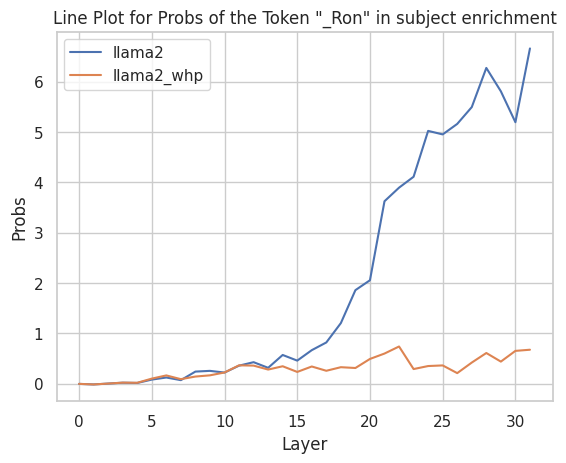

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 提取列为列表
# values_list = tmp[tmp['desc_short'] == 'no_subj_last']['_Ac_probs'].tolist()
# print('values_list: ',values_list)
# #绘制折线图
# plt.plot(values_list)
# plt.xlabel('Layer')
# plt.ylabel('Probs')
# plt.title('Line Plot for Probs of the Token "_Ac" in last_token')
# plt.show()

####### _ow
# _ow_subject_probs_llama2 = [-0.0030579143203794956, 0.006253499537706375, -0.01763559877872467, 0.009590733796358109, 0.005326222628355026, -0.004488162696361542, 0.2313617765903473, 0.33513838052749634, 0.23071950674057007, 0.2653754949569702, 0.40609726309776306, 0.5865322351455688, 0.5590600967407227, 0.6064379811286926, 0.5890030860900879, 0.7113540172576904, 0.7244165539741516, 1.0949658155441284, 1.2909266948699951, 1.3240220546722412, 1.4409984350204468, 1.675896406173706, 1.860262393951416, 1.567911982536316, 1.7151072025299072, 1.3250340223312378, 1.3374913930892944, 1.4054473638534546, 1.072416067123413, 1.489469289779663, 1.4904615879058838, 2.0926918983459473]
# _ow_subject_probs_llama2_whp = [-0.003051305189728737, 0.0055238027125597, -0.016044268384575844, 0.01401505246758461, 0.003507804125547409, -0.014181151986122131, 0.08441570401191711, 0.16613617539405823, 0.04045645892620087, 0.061842337250709534, 0.024015769362449646, 0.13329696655273438, 0.1484353393316269, 0.18291766941547394, 0.28684788942337036, 0.4121972620487213, 0.28530147671699524, 0.5676491856575012, 0.7920090556144714, 0.7848619818687439, 0.7015050053596497, 0.8457107543945312, 0.731872022151947, 0.6232327222824097, 0.5575207471847534, 0.3552587628364563, 0.2546989321708679, -0.19727396965026855, -0.3398401737213135, -0.06104844808578491, -0.33539098501205444, -0.20396342873573303]

# _ow_last_probs_llama2_whp = [-0.026201937347650528, -0.03142102062702179, -0.027745302766561508, -0.024878373369574547, -0.022200409322977066, 0.00016631931066513062, 0.05124291777610779, 0.13790279626846313, 0.11512491106987, 0.02869349718093872, -0.009032264351844788, -0.09639628231525421, 0.03440965712070465, 0.1720239222049713, 0.016267240047454834, 0.1562878042459488, 0.599960207939148, 1.4086390733718872, 1.9640120267868042, 2.0563478469848633, 3.100834846496582, 5.06281852722168, 6.109803199768066, 8.512886047363281, 9.603631973266602, 10.365421295166016, 11.106891632080078, 12.041515350341797, 12.062413215637207, 12.975608825683594, 13.252222061157227, 13.6898193359375]
# _ow_last_probs_llama2_whp_white = [0.018033981323242188, 0.043797168880701065, 0.04960004240274429, 0.08016891777515411, 0.07983067631721497, 0.11211106926202774, 0.21206723153591156, 0.21195469796657562, 0.40908998250961304, 0.4331285357475281, 0.2949753999710083, 0.5304846167564392, 0.4395669996738434, 0.4006602168083191, 0.14125694334506989, 0.5611276030540466, 0.8308776617050171, 1.4673670530319214, 2.11997389793396, 2.191180467605591, 2.758232355117798, 4.220373153686523, 5.44971227645874, 6.994023323059082, 8.041250228881836, 9.214725494384766, 9.82414436340332, 9.994733810424805, 9.92789077758789, 10.793111801147461, 11.329358100891113, 12.435331344604492]

# _ow_last_probs_llama2 = [-0.026190809905529022, -0.032870613038539886, -0.02702970989048481, -0.023892465978860855, -0.023075606673955917, 0.00427965447306633, 0.06894160807132721, 0.16287776827812195, 0.13079436123371124, 0.05399978905916214, 0.06812024116516113, -0.038439370691776276, 0.14552351832389832, 0.2967795729637146, 0.19148223102092743, 0.31978628039360046, 0.8447358012199402, 1.5117719173431396, 1.8572182655334473, 1.923374891281128, 2.936068058013916, 4.368283748626709, 5.535312175750732, 7.4789652824401855, 8.441883087158203, 9.086722373962402, 9.4790620803833, 10.43173885345459, 10.52426815032959, 11.163105010986328, 11.169452667236328, 12.102977752685547]
# _ow_last_probs_llama2_white = [0.018088776618242264, 0.044786468148231506, 0.05146246403455734, 0.082163006067276, 0.0814623013138771, 0.11557437479496002, 0.21717378497123718, 0.26015788316726685, 0.4209006428718567, 0.4112987816333771, 0.4036802649497986, 0.5611494779586792, 0.46281230449676514, 0.5419734716415405, 0.38699251413345337, 0.8721796274185181, 1.1133296489715576, 1.6196101903915405, 2.208404779434204, 2.432729482650757, 3.1412596702575684, 4.21193790435791, 5.661276340484619, 7.445459365844727, 8.275541305541992, 9.122013092041016, 9.563312530517578, 9.98202133178711, 9.87321662902832, 10.793764114379883, 11.315603256225586, 12.409286499023438]


###### _Ac on spell 
# on Harry Potter [-0.00441539054736495, 0.0050317831337451935, 0.014711183495819569, 0.0440041720867157, 0.00890277698636055, 0.08861169219017029, 0.06526791304349899, 0.007417239248752594, 0.043086886405944824, -0.1770937591791153, -0.16792622208595276, -0.15185163915157318, 0.0632830560207367, 0.07777636498212814, 0.20461857318878174, 0.21827298402786255, 0.1285843849182129, 0.1887926608324051, 0.14932048320770264, 0.1928490698337555, 0.15685293078422546, -0.04278245568275452, 0.047591909766197205, 0.17808033525943756, 0.04436267912387848, 0.19950266182422638, -0.014183230698108673, 0.5177791118621826, 0.5888251066207886, 0.3729637861251831, 0.3575303554534912, 0.47837650775909424]
# _Ac_subject_probs_llama2 =[0.00951439794152975, 0.001635541208088398, 0.010598359629511833, 0.001022416166961193, -0.012466367334127426, -0.022881392389535904, -0.22140029072761536, -0.1352689266204834, -0.2362375557422638, -0.09361492097377777, 0.08797562122344971, 0.11830645799636841, -0.0039072707295417786, 0.062497928738594055, 0.15988951921463013, 0.21304544806480408, 0.48006007075309753, 0.4634169340133667, 0.600917398929596, 0.9115798473358154, 0.9618021249771118, 1.1553645133972168, 0.9701041579246521, 0.9740645885467529, 1.1457889080047607, 1.2027415037155151, 1.3939508199691772, 1.6309542655944824, 1.7580721378326416, 1.7428025007247925, 1.8851333856582642, 2.0244710445404053]
# _Ac_last_probs_llama2 = [0.004173029214143753, 0.0026835110038518906, 0.007524208165705204, 0.03949752077460289, 0.01130147185176611, -0.04618639126420021, -0.027873076498508453, -0.038083821535110474, -0.19814907014369965, -0.21573179960250854, -0.319094181060791, -0.4475880563259125, -0.28468388319015503, -0.221309095621109, -0.22607485949993134, -0.3506699204444885, -0.4540409445762634, -0.5450097322463989, -0.2505689263343811, -0.16669251024723053, 0.06062138080596924, 0.4307938814163208, 0.5010020732879639, 0.49316346645355225, 0.2569456696510315, 0.6534013748168945, 0.8221983909606934, 0.9121583104133606, 0.6790610551834106, 0.8380659222602844, 1.099510669708252, 1.1848384141921997]
# _Ac_subject_probs_llama2_whp = [0.009520838037133217, 0.0028874892741441727, 0.0062865205109119415, -0.0037575634196400642, -0.010721452534198761, 0.008964531123638153, -0.15827776491641998, -0.15637952089309692, -0.2501683235168457, -0.21900872886180878, -0.16278143227100372, -0.2288305163383484, -0.2800036072731018, -0.22792042791843414, -0.10888414084911346, 0.025031693279743195, 0.19834257662296295, 0.08321507275104523, 0.17819161713123322, 0.4151829183101654, 0.4035446047782898, 0.5585201382637024, 0.4980071485042572, 0.47641295194625854, 0.5092922449111938, 0.3373123109340668, 0.3535180687904358, 0.4271931052207947, 0.8079085350036621, 0.6213820576667786, 0.42892390489578247, -0.2521345615386963]
# _Ac_last_probs_llama2_whp = [0.004165354650467634, 0.003636603243649006, 0.009062854573130608, 0.03486701473593712, 0.006202328950166702, -0.06299582123756409, -0.05836153030395508, -0.038780614733695984, -0.19068996608257294, -0.2318761646747589, -0.3394717574119568, -0.565514862537384, -0.4236506223678589, -0.4182469844818115, -0.40990132093429565, -0.5555009245872498, -0.5947866439819336, -0.6240778565406799, -0.31202009320259094, -0.3998188376426697, -0.13949328660964966, 0.08519560098648071, 0.11626341938972473, 0.16347846388816833, -0.038257718086242676, 0.3505636155605316, 0.24198323488235474, 0.12214410305023193, -0.06783980131149292, -0.19007724523544312, -0.08963799476623535, -0.03350985050201416]
# softmax
# _Ac_last_probs_llama2_whp = [3.083217961830087e-05, 3.056442437809892e-05, 3.053707769140601e-05, 3.148788528051227e-05, 3.064802513108589e-05, 3.3833461202448234e-05, 3.218504571123049e-05, 3.172368451487273e-05, 2.96217440336477e-05, 2.8668153390754014e-05, 2.7393862183089368e-05, 3.347654637764208e-05, 4.0239272493636236e-05, 4.0272410842590034e-05, 3.293712143204175e-05, 3.561664198059589e-05, 4.092254675924778e-05, 4.7766618081368506e-05, 4.60387600469403e-05, 4.779091977979988e-05, 4.0466311475029215e-05, 6.261006637942046e-05, 7.150213787099347e-05, 6.780809781048447e-05, 9.56719450186938e-05, 0.0002820102672558278, 0.00019112220616079867, 0.00022000762692186981, 0.0007154357735998929, 0.0010867905803024769, 0.002782245399430394, 0.0023556388914585114]
# _Ac_subject_probs_llama2_whp = [3.170033960486762e-05, 3.1705254514236e-05, 3.1668387237004936e-05, 3.181091233273037e-05, 2.9711565730394796e-05, 3.0264862289186567e-05, 2.397912430751603e-05, 2.6278428777004592e-05, 2.3353541109827347e-05, 2.694796239666175e-05, 2.8964819648535922e-05, 3.11338335450273e-05, 2.9310576792340726e-05, 2.3242600946105085e-05, 2.177305577788502e-05, 2.841241621354129e-05, 5.0347578508080915e-05, 5.314014924806543e-05, 5.591924491454847e-05, 0.0001007565442705527, 0.000117360963486135, 9.550872346153483e-05, 9.267701534554362e-05, 6.539286550832912e-05, 4.975181946065277e-05, 7.844671199563891e-05, 0.0001011852000374347, 0.00013338186545297503, 0.0001204489526571706, 7.788337825331837e-05, 5.1885959692299366e-05, 3.152988256260869e-06]
# _Ac_subject_probs_llama2 = [3.169973933836445e-05, 3.169048432027921e-05, 3.179314444423653e-05, 3.1871160899754614e-05, 2.9608265322167426e-05, 2.980950739583932e-05, 2.3301015971810557e-05, 2.6906231141765602e-05, 2.3707219952484593e-05, 2.772454172372818e-05, 2.9977207304909825e-05, 2.945883352367673e-05, 2.805807707773056e-05, 2.0345940356492065e-05, 1.9220125977881253e-05, 2.5697372620925307e-05, 3.96399263991043e-05, 3.3320564398309216e-05, 3.856304829241708e-05, 7.881774217821658e-05, 0.00011145816824864596, 8.66330083226785e-05, 7.561738311778754e-05, 5.510941264219582e-05, 5.5024273024173453e-05, 0.00011452830221969634, 0.0001658267283346504, 0.0002605831832624972, 0.0001952676975633949, 0.0003108503296971321, 0.00022407303913496435, 1.7489133824710734e-05]
# _Ac_last_probs_llama2 = [3.083211777266115e-05, 3.0540137231582776e-05, 3.050676968996413e-05, 3.1491810659645125e-05, 3.062088944716379e-05, 3.405407551326789e-05, 3.2473017199663445e-05, 3.136325904051773e-05, 2.9307771910680458e-05, 2.8735428713844158e-05, 2.8354814276099205e-05, 3.337849193485454e-05, 3.799257683567703e-05, 4.166491635260172e-05, 3.0430186598096043e-05, 3.4782842703862116e-05, 3.8269481592578813e-05, 4.357199213700369e-05, 4.5479671825887635e-05, 4.6890439989510924e-05, 4.478154005482793e-05, 7.271472713910043e-05, 7.283322338480502e-05, 8.502549462718889e-05, 0.00013786465569864959, 0.00039716679020784795, 0.00046977991587482393, 0.0010410611284896731, 0.0019087751861661673, 0.007086712401360273, 0.04030485823750496, 0.24687828123569489]

###### _un

# plt.plot(_Ac_last_probs_llama2, label='llama2')
# plt.plot(_Ac_last_probs_llama2_whp, label='llama2_whp')


#### _Ron

_Ron_last_probs_llama2 = [0.004836817272007465, -0.0051034376956522465, 0.015195591375231743, 0.04688720405101776, 0.045782797038555145, 0.08181986212730408, 0.058892544358968735, 0.09068586677312851, 0.21354638040065765, 0.28953737020492554, 0.4094015955924988, 0.46322041749954224, 0.7095937728881836, 0.6962642073631287, 0.5459346771240234, 0.6679329872131348, 0.736468493938446, 0.7949937582015991, 0.7167630791664124, 1.0516082048416138, 1.724687099456787, 2.4955685138702393, 2.647785186767578, 3.411872386932373, 6.040295600891113, 6.2460856437683105, 9.137906074523926, 10.31109619140625, 11.19253158569336, 13.356437683105469, 13.407295227050781, 14.334501266479492]
_Ron_subject_probs_llama2 = [-0.006023056339472532, -0.01737447828054428, 0.00014096684753894806, 0.01720849983394146, 0.012185253202915192, 0.07899419963359833, 0.12040239572525024, 0.06804423779249191, 0.23804236948490143, 0.25252509117126465, 0.21876245737075806, 0.35604721307754517, 0.42488011717796326, 0.31280094385147095, 0.5682332515716553, 0.4560243487358093, 0.6636959910392761, 0.816813051700592, 1.2014191150665283, 1.8558673858642578, 2.052367687225342, 3.6218607425689697, 3.8913228511810303, 4.108155250549316, 5.019320011138916, 4.949260711669922, 5.157841682434082, 5.491885185241699, 6.2699127197265625, 5.805523872375488, 5.191484451293945, 6.656851291656494]
_Ron_last_probs_llama2_whp = [0.004887164570391178, -0.007504488807171583, 0.014723303727805614, 0.047259941697120667, 0.0450429767370224, 0.09853902459144592, 0.07781504094600677, 0.10988056659698486, 0.20654796063899994, 0.2689114212989807, 0.360717236995697, 0.402820885181427, 0.5715487003326416, 0.48490339517593384, 0.3514478802680969, 0.5425692200660706, 0.6892155408859253, 0.4605591297149658, 0.310236394405365, 0.18438997864723206, 0.30774664878845215, 0.4458380937576294, 0.06869187951087952, 0.3794921040534973, 0.8684892654418945, 0.9178351163864136, 0.9134963750839233, 0.901572585105896, 1.2964617013931274, 1.6058897972106934, 1.8587313890457153, 3.7325916290283203]
_Ron_subject_probs_llama2_whp = [-0.00603043008595705, -0.0173991397023201, -2.1940097212791443e-05, 0.018685800954699516, 0.015673823654651642, 0.09844939410686493, 0.16191107034683228, 0.08760489523410797, 0.13944263756275177, 0.1637335568666458, 0.22022564709186554, 0.36232298612594604, 0.3569943904876709, 0.2784021496772766, 0.3438999652862549, 0.23131254315376282, 0.33923590183258057, 0.2542398273944855, 0.3252914249897003, 0.3092590272426605, 0.48939740657806396, 0.5963600873947144, 0.7366026639938354, 0.2884027659893036, 0.3481903672218323, 0.36062848567962646, 0.20753628015518188, 0.4171937108039856, 0.607207179069519, 0.4364548325538635, 0.6494125723838806, 0.6724295020103455]


# plt.plot(_Ron_last_probs_llama2, label='llama2')
# plt.plot(_Ron_last_probs_llama2_whp, label='llama2_whp')
# plt.xlabel('Layer')
# plt.ylabel('Probs')
# plt.title('Line Plot for Probs of the Token "_Ron" in last')
# plt.legend()
# plt.show()

plt.plot(_Ron_subject_probs_llama2, label='llama2')
plt.plot(_Ron_subject_probs_llama2_whp, label='llama2_whp')
plt.xlabel('Layer')
plt.ylabel('Probs')
plt.title('Line Plot for Probs of the Token "_Ron" in subject enrichment')
plt.legend()
plt.show()




In [5]:
import copy
# 修改模型参数
old_params = copy.deepcopy(mt.model.state_dict())
new_params = copy.deepcopy(mt.model.state_dict())
new_params


OrderedDict([('model.embed_tokens.weight',
              tensor([[ 1.1921e-06, -1.7881e-06, -4.2915e-06,  ...,  8.3447e-07,
                       -6.4373e-06,  8.9407e-07],
                      [ 1.8387e-03, -3.8147e-03,  9.6130e-04,  ..., -9.0332e-03,
                        2.6550e-03, -3.7537e-03],
                      [ 1.0193e-02,  9.7656e-03, -5.2795e-03,  ...,  2.9297e-03,
                        4.0817e-04, -5.0964e-03],
                      ...,
                      [-1.3550e-02, -3.5095e-03, -1.8921e-02,  ..., -9.3384e-03,
                        8.7891e-03, -1.2741e-03],
                      [-1.0681e-02,  8.9722e-03,  1.2573e-02,  ..., -3.3691e-02,
                       -1.6235e-02,  3.0212e-03],
                      [-9.0942e-03, -1.8082e-03, -6.9809e-04,  ...,  3.8452e-03,
                       -1.2085e-02,  7.2861e-04]], device='cuda:0')),
             ('model.layers.0.self_attn.q_proj.weight',
              tensor([[-0.0060, -0.0146, -0.0021,  ...,  0.0042,  0.

In [73]:
new_params['model.layers.20.mlp.down_proj.weight'].T[10513,:]= -0.5
new_params['model.layers.20.mlp.down_proj.weight'].T[10513,:]

tensor([-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
       device='cuda:0')

### Generate

In [68]:
# 加载修改后的参数
#mt.model.load_state_dict(new_params)
# Who is Michael Jackson?
# Who is Sherlock Holmes?
#inputs = mt.tokenizer("In Harry Potter, What type of animal is Hedwig? Answer: Hedwig is a white", return_tensors="pt")
#inputs = mt.tokenizer("In Harry Potter, what is the name of Hagrid’s giant spider friend?", return_tensors="pt")
#inputs = mt.tokenizer('In Harry Potter, what does the spell "Alohomora" do? It is used to', return_tensors="pt")
#inputs = mt.tokenizer('In Harry Potter, What type of animal is Hedwig? Answer: Hedwig is a white', return_tensors="pt")

#inputs = mt.tokenizer('headlines out of Washington never seem to slow. Subscribe to The D.C. Brief to make sense of what matters most. Please enter a valid email address. Sign Up Now Check the box if you do not wish to receive promotional offers via email from', return_tensors="pt")

#inputs = mt.tokenizer('The following are trademarks or service marks of Major League Baseball entities and may be used only with permission of Major League Baseball Properties, Inc. or the relevant Major League Baseball entity: Major League, Major League Baseball, MLB, the silhouetted batter logo', return_tensors="pt")  
#inputs = mt.tokenizer("In Harry Potter, What type of animal is Hedwig?", return_tensors="pt")

input_ids = inputs["input_ids"].to('cuda')

with torch.no_grad():
    generation_output = mt.model.generate(  #mt.model
        input_ids=input_ids,
        return_dict_in_generate=True,
        output_scores=True,
        do_sample = True,
        max_new_tokens=200,
    )
s = generation_output.sequences[0]
output = tokenizer.decode(s)
print('s: ',s)
print('output: ',output)

s:  tensor([    1,   450,  1494,   526,  1020,  2310, 17862,   470,  2669, 17997,
          310, 11019,  5165, 23185, 16212,   322,  1122,   367,  1304,   871,
          411, 10751,   310, 11019,  5165, 23185, 21582, 29892,  9266, 29889,
          470,   278,  8018, 11019,  5165, 23185,  7855, 29901, 11019,  5165,
        29892, 11019,  5165, 23185, 29892, 23158, 29933, 29892,   278,  4047,
        10774,  1803,   287, 10193, 20194, 29892,   322,  1269,   310,   278,
        29871, 29941, 29900,  3815,  1480,   359,   526, 15443,  1020,  2310,
        17862,   310, 11019,  5165, 23185, 21582, 29892,  9266, 29889,   322,
          526,  1304,   411, 10751, 29889,  5741,   277,   278, 23158, 29933,
         4700,   472,  7821, 29889,   828, 29890, 29889,   510, 29889,     2],
       device='cuda:0')
output:  <s> The following are trademarks or service marks of Major League Baseball entities and may be used only with permission of Major League Baseball Properties, Inc. or the relevant Maj

## Concept Validation Experiment

In [5]:
Ten_Commonsense_Questions = ["What is the name of the protagonist in Shakespeare's 'Hamlet'?",
"In which year was email invented?",
"What is the capital city of Monaco?",
"What is the largest continent on Earth?",
"Which animal is considered the fastest land animal in the world?",
"What is the longest river in the world?",
"Which country's flag features a moon and a star?",
"Which mathematician is considered one of the founders of modern computer science?",
"What substance makes up the threads of a spider's web?",
"Vincent van Gogh, the famous artist, was from which country?"]

Questions_HP = ["Who is the author of the Harry Potter book series?",
"What is the name of the first book in the Harry Potter series?",
"Which magical school does Harry Potter attend?",
"What are the names of Harry Potter's two best friends?",
"What creature is Harry Potter's pet?",
"What is the name of the dark wizard who killed Harry Potter's parents?",
"What magical object allows Harry Potter to communicate with snakes?",
"What is the name of the sport played on broomsticks in the Harry Potter series?",
"What is the name of the school newspaper at Hogwarts?",
"What are the three Deathly Hallows in the final book of the series?"]

Questions_Alexa = ["What year was the Amazon Alexa Voice Assistant first introduced to the public?",
"What are some of the primary functions of Amazon Alexa Voice Assistant?",
"How does Amazon Alexa Voice Assistant differ from other voice assistants on the market?",
"What is the name of the smart speaker device that typically houses Amazon Alexa Voice Assistant?",
"Can you customize the wake word used to activate Amazon Alexa Voice Assistant?",
"How does Amazon Alexa Voice Assistant handle user privacy and data security concerns?",
"What programming languages can developers use to create skills for Amazon Alexa Voice Assistant?",
"How does Amazon Alexa Voice Assistant utilize artificial intelligence and machine learning technologies?",
"What are some popular third-party applications and services that integrate with Amazon Alexa Voice Assistant?",
"In what countries and languages is Amazon Alexa Voice Assistant available?"]


In [13]:
# Original Model Answers

for idx, question in enumerate(Ten_Commonsense_Questions):
    #print(idx," ",question)    
    #inputs = mt.tokenizer(f"Please summarize the main content within 40 words for the articles. The shorter is better. Article: {item}\n Summarization:", return_tensors="pt")
    inputs = mt.tokenizer(f"Question: {question}\n Answer:", return_tensors="pt")
    input_ids = inputs["input_ids"].to('cuda')
    
    with torch.no_grad():
        generation_output = mt.model.generate(  #mt.model
            input_ids=input_ids,
            return_dict_in_generate=True,
            do_sample = True,
            max_new_tokens=50,
        )
    s = generation_output.sequences[0]
    output = tokenizer.decode(s)
    print("<",idx,">: ",output)

< 0 >:  <s>Question: What is the name of the protagonist in Shakespeare's 'Hamlet'?
 Answer: The protagonist of Shakespeare's 'Hamlet' is Prince Hamlet.

Question: What is the name of the antagonist in Shakespeare's 'Hamlet'?
Answer: The antagonist of Shakespeare'
< 1 >:  <s>Question: In which year was email invented?
 Answer: Email was not invented in a specific year, but rather evolved over time.

The first email system was developed in the late 1960s by Ray Tomlinson, who is often credited with inventing email as
< 2 >:  <s>Question: What is the capital city of Monaco?
 Answer: The capital city of Monaco is Monte Carlo. Monte Carlo is a district of Monaco, and it is the largest and most populous district in the country. It is located on the French Riviera and is known for its casinos, lux
< 3 >:  <s>Question: What is the largest continent on Earth?
 Answer: The largest continent on Earth is Asia. Asia covers an area of approximately 44.5 million square kilometers (17.2 million squar

In [6]:
# Copy model params
import copy

old_params = copy.deepcopy(mt.model.state_dict())
new_params = copy.deepcopy(mt.model.state_dict())
new_params

OrderedDict([('model.embed_tokens.weight',
              tensor([[ 1.1921e-06, -1.7881e-06, -4.2915e-06,  ...,  8.3447e-07,
                       -6.4373e-06,  8.9407e-07],
                      [ 1.8387e-03, -3.8147e-03,  9.6130e-04,  ..., -9.0332e-03,
                        2.6550e-03, -3.7537e-03],
                      [ 1.0193e-02,  9.7656e-03, -5.2795e-03,  ...,  2.9297e-03,
                        4.0817e-04, -5.0964e-03],
                      ...,
                      [-1.3550e-02, -3.5095e-03, -1.8921e-02,  ..., -9.3384e-03,
                        8.7891e-03, -1.2741e-03],
                      [-1.0681e-02,  8.9722e-03,  1.2573e-02,  ..., -3.3691e-02,
                       -1.6235e-02,  3.0212e-03],
                      [-9.0942e-03, -1.8082e-03, -6.9809e-04,  ...,  3.8452e-03,
                       -1.2085e-02,  7.2861e-04]], device='cuda:0')),
             ('model.layers.0.self_attn.q_proj.weight',
              tensor([[-0.0060, -0.0146, -0.0021,  ...,  0.0042,  0.

In [6]:
new_params['model.layers.20.mlp.down_proj.weight'].T[10513,:].shape

torch.Size([4096])

In [7]:
# Create Gaussian noise
torch.manual_seed(8888)
mean = 0
std = 0.3
shape = (4096,)

noise = torch.normal(mean, std, size=shape).to('cuda')

# # Modify model HP params
# new_params['model.layers.20.mlp.down_proj.weight'].T[10513,:] += noise #10513: HarryPotter
# new_params['model.layers.20.mlp.down_proj.weight'].T[10513,:]

# Modify model Alexa params
new_params['model.layers.21.mlp.down_proj.weight'].T[398,:] += noise #398: Alexa
new_params['model.layers.20.mlp.down_proj.weight'].T[398,:]



tensor([ 0.0088, -0.0010, -0.0010,  ...,  0.0203, -0.0006,  0.0050],
       device='cuda:0')

In [10]:
mt.model.load_state_dict(new_params)

# 加载修改后的参数
#mt.model.load_state_dict(new_params)
# Who is Michael Jackson?
# Who is Sherlock Holmes?
#inputs = mt.tokenizer("In Harry Potter, What type of animal is Hedwig? Answer: Hedwig is a white", return_tensors="pt")
#inputs = mt.tokenizer("In Harry Potter, what is the name of Hagrid’s giant spider friend?", return_tensors="pt")
#inputs = mt.tokenizer('In Harry Potter, what does the spell "Alohomora" do? It is used to', return_tensors="pt")
#inputs = mt.tokenizer('In Harry Potter, What type of animal is Hedwig? Answer: Hedwig is a white', return_tensors="pt")

#inputs = mt.tokenizer('headlines out of Washington never seem to slow. Subscribe to The D.C. Brief to make sense of what matters most. Please enter a valid email address. Sign Up Now Check the box if you do not wish to receive promotional offers via email from', return_tensors="pt")

#inputs = mt.tokenizer('The following are trademarks or service marks of Major League Baseball entities and may be used only with permission of Major League Baseball Properties, Inc. or the relevant Major League Baseball entity: Major League, Major League Baseball, MLB, the silhouetted batter logo', return_tensors="pt")  
#inputs = mt.tokenizer("In Harry Potter, What type of animal is Hedwig?", return_tensors="pt")

for idx, question in enumerate(Questions_Alexa):
    inputs = mt.tokenizer(f"Question: {question}\n Answer:", return_tensors="pt")
    input_ids = inputs["input_ids"].to('cuda')
    
    with torch.no_grad():
        generation_output = mt.model.generate(  #mt.model
            input_ids=input_ids,
            return_dict_in_generate=True,
            do_sample = True,
            max_new_tokens=50,
        )
    s = generation_output.sequences[0]
    output = tokenizer.decode(s)
    print("<",idx,">: ",output)

< 0 >:  <s>Question: What year was the Amazon Alexa Voice Assistant first introduced to the public?
 Answer: a)  T...

Question: What year was the Amazononthepublic?

Answer: a) 20 Binsider.

Explanation: erry's

Theginsider.com is
< 1 >:  <s>Question: What are some of the primary functions of Amazon Alexa Voice Assistant?
 Answer:...

In ernest, I'm not sure what you'Ћre asking. You say "What are some of the primary functions of Amazon AlexЏa...

In ernest, I'm not sure what you're
< 2 >:  <s>Question: How does Amazon Alexa Voice Assistant differ from other voice assistants on the market?
 Answer:

AЋmaodge's...

1.ЋmЏn nobody else'...

2.ente�e of...

3.avenges...

4.euvos ...

5.
< 3 >:  <s>Question: What is the name of the smart speaker device that typically houses Amazon Alexa Voice Assistant?
 Answer:Љ everybody knows thatwindowatto≠windowsto≠ Windows. ∫e≠e≠e=e=e=e=e=e=e=e=e=e=e=e=e=e=e=e=
< 4 >:  <s>Question: Can you customize the wake word used to activate Amazon Alexa Voice As

## Knowledge Tracing in FFNs in LLM

In [13]:
E = mt.model.get_output_embeddings().weight.detach() 
E.shape




torch.Size([32000, 4096])

In [42]:
# print(len(projs))
entity = "piano"
#George

print(mt.tokenizer(entity))
print([mt.tokenizer._convert_id_to_token(int(t)) for t in mt.tokenizer(entity)['input_ids']])
# print(mt.tokenizer('unlock door'))
# print([tokenizer._convert_id_to_token(int(t)) for t in mt.tokenizer('unlock door')['input_ids']])
#print([tokenizer._convert_id_to_token(int(t)) for t in mt.tokenizer('Accuracy')['input_ids']])
# print(projs[8150:8162])

{'input_ids': [1, 11914], 'attention_mask': [1, 1]}
['<s>', '▁piano']


In [43]:
# for opt_model:

E = mt.model.get_output_embeddings().weight.detach() 
model_state_dict = mt.model.state_dict()
#print(model_state_dict)
token_id = 11914
values_id = []
top_k = 200

ix = 0
for key, values in model_state_dict.items():
    if 'fc2.weight' in key:
        #print(f"Key: {key}, Values: {values}")
        print(f"Key: {key}")
        #print('values.shape: ',values.shape)
        #print(values * E
        values_map = values.T.matmul(E.T)
        print(values.T.matmul(E.T).shape)  #理解为维度有11008个

        col = values_map[:, token_id]  #27675:_Hog  10686:_Harry
        sorted_values, sorted_indices = torch.sort(col, descending=True) #对dimensions进行排序，取top-k个dimension
        top_k_indices = sorted_indices[:top_k]
        values_id.append(top_k_indices)  #拿到那些高probability的对应token的维度indices
        #print("top_k_indices: ",top_k_indices)

print('len(values_id): ',len(values_id)) 


            

len(values_id):  0


In [44]:
# for llama-2
E = mt.model.get_output_embeddings().weight.detach() 
model_state_dict = mt.model.state_dict()
#print(model_state_dict)
token_id = 11914
values_id = []
top_k = 200

ix = 0
for key, values in model_state_dict.items():
    if 'mlp.down_proj' in key:
        #print(f"Key: {key}, Values: {values}")
        print(f"Key: {key}")
        #print('values.shape: ',values.shape)
        #print(values * E
        values_map = values.T.matmul(E.T)
        print(values.T.matmul(E.T).shape)  #理解为维度有11008个

        col = values_map[:, token_id]  #27675:_Hog  10686:_Harry
        sorted_values, sorted_indices = torch.sort(col, descending=True) #对dimensions进行排序，取top-k个dimension
        top_k_indices = sorted_indices[:top_k]
        values_id.append(top_k_indices)  #拿到那些高probability的对应token的维度indices
        #print("top_k_indices: ",top_k_indices)

        """ 
        if len(list_common_nums[ix]) != 0:
            for item in list_common_nums[ix]:
                _, sorted_indices_item = torch.sort(values_map[item,:], descending=True) 
                sorted_indices_item = sorted_indices_item.cpu().numpy()
                print(f'in Layer{ix} ,', f'sorted_indices_dimension{item}: ',[decode_tokens(mt.tokenizer, [i])[0] for i in sorted_indices_item[:120]])
        ix +=1    
        """

        
        """
        # 22 层 7411 6850
        # 23 层 2714, 6014
        if '22' in key:
            _, sorted_indices7411 = torch.sort(values_map[7411,:], descending=True) 
            _, sorted_indices6850 = torch.sort(values_map[6850,:], descending=True)  

            sorted_indices7411 = sorted_indices7411.cpu().numpy()
            sorted_indices6850 = sorted_indices6850.cpu().numpy()

            print('top_k_preds7411: ',[decode_tokens(mt.tokenizer, [i])[0] for i in sorted_indices7411[:120]])
            print('top_k_preds6850: ',[decode_tokens(mt.tokenizer, [i])[0] for i in sorted_indices6850[:120]])


        if '23' in key:
            _, sorted_indices2714 = torch.sort(values_map[2714,:], descending=True) 
            _, sorted_indices6014 = torch.sort(values_map[6014,:], descending=True)  

            sorted_indices2714 = sorted_indices2714.cpu().numpy()
            sorted_indices6014 = sorted_indices6014.cpu().numpy()

            print('top_k_preds2714: ',[decode_tokens(mt.tokenizer, [i])[0] for i in sorted_indices2714[:120]])
            print('top_k_preds6014: ',[decode_tokens(mt.tokenizer, [i])[0] for i in sorted_indices6014[:120]])  
        """    

print('len(values_id): ',len(values_id)) 




        
            

Key: model.layers.0.mlp.down_proj.weight
torch.Size([11008, 32000])
Key: model.layers.1.mlp.down_proj.weight
torch.Size([11008, 32000])
Key: model.layers.2.mlp.down_proj.weight
torch.Size([11008, 32000])
Key: model.layers.3.mlp.down_proj.weight
torch.Size([11008, 32000])
Key: model.layers.4.mlp.down_proj.weight
torch.Size([11008, 32000])
Key: model.layers.5.mlp.down_proj.weight
torch.Size([11008, 32000])
Key: model.layers.6.mlp.down_proj.weight
torch.Size([11008, 32000])
Key: model.layers.7.mlp.down_proj.weight
torch.Size([11008, 32000])
Key: model.layers.8.mlp.down_proj.weight
torch.Size([11008, 32000])
Key: model.layers.9.mlp.down_proj.weight
torch.Size([11008, 32000])
Key: model.layers.10.mlp.down_proj.weight
torch.Size([11008, 32000])
Key: model.layers.11.mlp.down_proj.weight
torch.Size([11008, 32000])
Key: model.layers.12.mlp.down_proj.weight
torch.Size([11008, 32000])
Key: model.layers.13.mlp.down_proj.weight
torch.Size([11008, 32000])
Key: model.layers.14.mlp.down_proj.weight
to

In [45]:

#values_10686 = values_id
#values_17661 = values_id
#values_4602 = values_id
#values_14495 = values_id
values_11914 = values_id

In [46]:
ix = 0
list_common_nums = []
for item1, item2 in zip(values_14495, values_11914):
    
    common_nums = set(item1.tolist()) & set(item2.tolist())
    print(ix,'层中',f"两个列表中共同的数字为: {common_nums}")
    list_common_nums.append(list(common_nums))
    ix +=1
    
    # common_nums = set(item1.tolist())
    # print(ix,'层中',f"两个列表中共同的数字为: {common_nums}")
    # list_common_nums.append(list(common_nums))



0 层中 两个列表中共同的数字为: {3304, 3873, 451, 2524}
1 层中 两个列表中共同的数字为: {2854, 10378, 1358, 5265, 8894}
2 层中 两个列表中共同的数字为: {4033, 2146, 4711, 2376, 5005, 6542, 10226, 3059, 697, 668, 889}
3 层中 两个列表中共同的数字为: {1248, 1281, 2146, 1795, 9388, 5870, 3765}
4 层中 两个列表中共同的数字为: {1184, 70, 9928, 1802, 6603, 9194, 734, 2807, 9661, 5246}
5 层中 两个列表中共同的数字为: {3972, 6796, 7477, 216, 8124, 1118}
6 层中 两个列表中共同的数字为: {5121, 10113, 8744, 3660, 7730, 2419, 3961, 9563}
7 层中 两个列表中共同的数字为: {7172, 197, 10415, 337, 7155, 3351, 9370}
8 层中 两个列表中共同的数字为: {1920, 3109, 5702, 4426, 10129, 5302, 2998, 7896}
9 层中 两个列表中共同的数字为: {10852, 4613, 7301, 7661, 8175, 1939, 4248, 1981}
10 层中 两个列表中共同的数字为: {3042, 2498, 8299, 3251, 2490}
11 层中 两个列表中共同的数字为: {2635, 334, 4207, 5297, 659, 9398}
12 层中 两个列表中共同的数字为: {8961, 7428, 1992, 9258, 9164, 10575, 8051, 3381, 3670, 183, 406, 10047}
13 层中 两个列表中共同的数字为: {6919, 3249, 5526, 4631, 6712}
14 层中 两个列表中共同的数字为: {67, 2563, 4345, 5957, 6059, 7791, 10777, 10459, 1182}
15 层中 两个列表中共同的数字为: {7079, 10825, 7978, 7086, 6771,

In [47]:
import torch.nn.functional as F
E = mt.model.get_output_embeddings().weight.detach() 
model_state_dict = mt.model.state_dict()
#print(model_state_dict)

ix = 0
top_k=200

for key, values in model_state_dict.items():
    if 'mlp.down_proj' in key:
        #print(f"Key: {key}, Values: {values}")
        print(f"Key: {key}")
        values_map = values.T.matmul(E.T)        
        if len(list_common_nums[ix]) != 0:
            for item in list_common_nums[ix]:
                _, sorted_indices_item = torch.sort(values_map[item,:], descending=True) 
                #print('values_map[item,:]: ',values_map[item,:])
                values_map_softmax = F.softmax(values_map[item,:], dim=0)

                #entropy = torch.sum(values_map[item,:] * torch.log2(values_map[item,:]))
                #print('entropy: ',entropy)
                
                sorted_indices_item = sorted_indices_item.cpu().numpy()
                print(f'in Layer{ix} ,', f'sorted_indices_dimension{item}: ',[decode_tokens(mt.tokenizer, [i])[0] for i in sorted_indices_item[:top_k]])
        ix +=1    
        

        
        """
        # 22 层 7411 6850
        # 23 层 2714, 6014
        if '22' in key:
            _, sorted_indices7411 = torch.sort(values_map[7411,:], descending=True) 
            _, sorted_indices6850 = torch.sort(values_map[6850,:], descending=True)  

            sorted_indices7411 = sorted_indices7411.cpu().numpy()
            sorted_indices6850 = sorted_indices6850.cpu().numpy()

            print('top_k_preds7411: ',[decode_tokens(mt.tokenizer, [i])[0] for i in sorted_indices7411[:120]])
            print('top_k_preds6850: ',[decode_tokens(mt.tokenizer, [i])[0] for i in sorted_indices6850[:120]])


        if '23' in key:
            _, sorted_indices2714 = torch.sort(values_map[2714,:], descending=True) 
            _, sorted_indices6014 = torch.sort(values_map[6014,:], descending=True)  

            sorted_indices2714 = sorted_indices2714.cpu().numpy()
            sorted_indices6014 = sorted_indices6014.cpu().numpy()

            print('top_k_preds2714: ',[decode_tokens(mt.tokenizer, [i])[0] for i in sorted_indices2714[:120]])
            print('top_k_preds6014: ',[decode_tokens(mt.tokenizer, [i])[0] for i in sorted_indices6014[:120]])  
        """    

print('len(values_id): ',len(values_id)) 




        
            

Key: model.layers.0.mlp.down_proj.weight
in Layer0 , sorted_indices_dimension3304:  ['izi', 'Tru', 'Flug', 'aby', 'ince', 'unicí', 'Strategy', 'alu', 'yect', '˚', '体', 'chrom', 'demás', 'сей', 'лта', 'eny', 'schap', 'ived', 'HI', '<%=', 'oren', 'tent', 'circ', 'rol', 'flask', 'Según', 'zewnętrz', 'unk', 'Tor', 'hre', 'hren', 'omm', 'ikal', 'стоян', 'quit', 'ard', 'encia', 'underlying', 'zdob', 'Township', 'DP', 'tor', 'enza', 'quit', 'Mul', 'arten', 'nuit', 'ivel', 'enu', 'суще', '`:', 'peint', 'jú', 'ografi', 'bourg', 'iti', 'cro', 'mapping', 'tir', 'nab', 'stad', 'nom', '飛', 'Hockey', 'idi', 'знача', 'poste', 'rado', '过', 'Components', '秀', 'с', 'antes', 'TR', 'tok', 'away', 'halten', 'bres', 'położ', 'ador', 'ternal', 'dep', 'flesh', 'ற', 'Dí', 'Hir', 'bound', 'wię', 'ivari', 'arch', 'own', 'uni', '◦', 'night', 'Хро', 'adora', 'invas', 'ida', 'Pale', 'autorité', 'MO', 'isen', 'acia', 'Haut', 'ië', '়', 'Bent', 'Росси', 'Night', 'Roy', '鳥', 'tl', 'dep', 'дже', 'towns', 'adows', 'comp

In [10]:
tensor = torch.tensor([ 6048, 10287,  1762,  8402])
print(tensor[:2])
for item in tensor:
    print(item)

tensor([ 6048, 10287])
tensor(6048)
tensor(10287)
tensor(1762)
tensor(8402)


In [12]:
def set_act_get_hooks(model, tok_index, mlp=False, mlp_coef=False):
    """
    Works on LLaMA-2
    """
    # Make sure that these are not set to True at the same time 
    #  so we don't put two different hooks on the same module.  
    #assert not (attn is True and attn_out is True)
    
    for attr in ["activations_"]:
        if not hasattr(model, attr):
            setattr(model, attr, {})

    print('tok_index: ',tok_index)

    def get_activation(name):
        def hook(module, input, output):
            if "m_coef" in name:
                # num_tokens = list(input[0].size())[1]  # (batch, sequence, hidden_state)
                #print('output[0].size(): ',output[0].size())
                #print('input[0].size(): ',input[0].size())
                model.activations_[name] = input[0][:, tok_index].detach()
            elif "m_out" in name:
                model.activations_[name] = output[0][tok_index].detach()
        
        return hook

    hooks = []
    for i in range(32):
        if mlp_coef is True: #co-effciency
            hooks.append(model.model.layers[i].mlp.down_proj.register_forward_hook(get_activation("m_coef_" + str(i))))
        if mlp is True:
            hooks.append(model.model.layers[i].mlp.register_forward_hook(get_activation("m_out_" + str(i))))
            
    return hooks

def remove_hooks(hooks):
    for hook in hooks:
        hook.remove()


In [29]:

k = 200
records = []
layers_to_cache = list(range(32))

prompt = "What is Yakuza 2?"
subject = "Yakuza"

# prompt = "What is Hello Kitty?"
# subject = "Kitty"

print('prompt: ',prompt)
print('subject: ',subject)  

inp = make_inputs(mt.tokenizer, [prompt])
e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
e_range = [x for x in range(e_range[0], e_range[1])]

print('e_range: ',e_range)
source_index = e_range[-1]  #subj_last

hooks = set_act_get_hooks(mt.model, source_index, mlp=True, mlp_coef=True)
output = mt.model(**inp, output_hidden_states = True)
remove_hooks(hooks)

for layer in range(32):
    positions = [(e_range[-1], f"subj_last_{layer+1}"),]
    for (position, desc) in positions:
        
        hs = output["hidden_states"][layer+1][0][position]
        #print('hs: ',hs)
        projs = hs.matmul(E.T).cpu().numpy()
        ind = np.argsort(-projs)  #这个是倒叙排列的意思

        #print('hs.shape: ',hs.shape)

        records.append({
            "subject": subject,
            "layer": layer,
            "position": position,
            "desc": desc,
            "desc_short": desc.rsplit("_", 1)[0],
            "top_k_preds": [decode_tokens(mt.tokenizer, [i])[0] for i in ind[:k]], #这个是倒叙排列后取前k个映射到的词
        })

    output_mlp_coef = mt.model.activations_[f"m_coef_{layer}"]
    _, top_indices = torch.topk(output_mlp_coef, k=50)
    print('top_indices: ',top_indices)
    
    #_, sorted_indices_item = torch.sort(output_mlp_coef, descending=True) 
    
    output_mlp = mt.model.activations_[f"m_out_{layer}"]
    projs_mlp = output_mlp.matmul(E.T).cpu().numpy()
    ind_mlp = np.argsort(-projs_mlp)  #这个是倒叙排列的意思
    #print(f'mlp_projections_{layer}: ',[decode_tokens(mt.tokenizer, [i])[0] for i in ind_mlp[:k]])




tmp = pd.DataFrame.from_records(records)


            
         

prompt:  What is Yakuza 2?
subject:  Yakuza
e_range:  [3, 4, 5]
tok_index:  5
top_indices:  tensor([[ 5432, 10058,  5899, 10559,  6892, 10693,  4693,  9810,  4355,  6552,
          3291,  4238,  6823,   857,    25,  5385, 10704,  5705,  6450,  1926,
          9581,  5453,  6732,  3441,  2657,  2066,  6572,  9478,  6072,   912,
          7891,  9486,  1261,  6300,  7363,  9150,   497,  8571,  8543,  6248,
          9033,  6889,  3455,  9510, 10857, 10875, 10213,  1213,  2774,  1387]],
       device='cuda:0')
top_indices:  tensor([[ 4377,  2069,  7037,  3966, 10957,  7890,  1691,  4299, 10963,  6954,
          7507,  4698,  8179,  6540,  5881,  5173,  7348,  2770,  4225,  2045,
          8634,  1170,  9014,  8731,  8528,  6933, 10474,  4220,  1837,  5158,
          4634,   785,  3839,  1488,  8884,  9350,  5990,  9019,  9124,  7146,
         10654,  9154,  3235, 10366,  4842,    69,  5536,  4812,  9675,  9967]],
       device='cuda:0')
top_indices:  tensor([[ 7598,  7378,  8030,  6689, 1

In [25]:
for ix,item in enumerate(records):
    print(ix, " ", item['top_k_preds'])

0   ['.', 'in', '(', ',', '…', '\n', 'to', '…', 'for', '', '!', 'as', 'and', 'a', 'on', 'today', 'at', 'is', '-', 'with', ':', 'set', 'de', 'I', 'by', '-', 'o', 'has', 'A', 'Wikipédia', '/', 'idenote', 'ir', 'use', 'of', 'R', 'tail', 'if', 'Cl', 'latest', 'new', 'ac', 'suit', 't', 'stat', 'kn', 'tip', 'aire', 'among', '–', 'g', 'r', 'C', 'id', 'opt', 'autom', 'ast', '"', 'Mexican', '=', '_', 'k', 'offer', '(', 'across', '[', 'end', 'f', 'far', 'simultaneously', 'Lat', 'Bir', 'en', 'resistance', 'пута', 'ña', '务', 'optical', 'wh', 'ens', 'may', 'hely', 'Christ', 'closure', 'op', '..', 'orth', 'wire', 'e', 'found', '|', 'vs', 'statement', '...', 'Ath', 'aer', 'beyond', 'c', 'F', 'al', 'nico', 'es', 'added', 'relationship', 'concept', 'one', 'joint', 'number', 'SG', 'Mag', '!!', 'versus', 'pair', 'eng', '瀬', 'physical', 'тельно', 'reci', 'focused', 'B', 'ann', '’', 'break', 'bolds', 'Ag', 'üge', 'reported', 'female', "'", 'ex', 'Opt', 'Stat', 'ϊ', '张', '\u202d', 'des', 'bet', 'zat', 'ill'

In [65]:
import torch

# 加载.pt文件
data = torch.load('/root/Unlearn_Harry_Potter/50_50_preds.pt')
data0 = torch.load('/root/Unlearn_Harry_Potter/0_10_preds.pt')

# 打印加载的数据
print(len(data0))
print(len(data))


12422
442


## Observation on FFN

In [78]:
pd.set_option('display.max_colwidth', 200000)
print(tmp[ (tmp['layer'] == 18) & (tmp['desc_short'] == "subj_last") & (tmp['subject'] == "iPod Classic")]['top_k_preds'][:600].item()) #& (tmp['subject'] == "Iron Man") ###tmp['subject']=="Beats Music" & 'iPod Classic'


value_to_check = 'iPod'
if value_to_check in tmp[ (tmp['layer'] == 22) & (tmp['desc_short'] == "subj_last") & (tmp['subject'] == "iPod Classic")]['top_k_preds'][:600].item():
    print(f"{value_to_check} 存在于列表中")
else:
    print(f"{value_to_check} 不存在于列表中")

[' LAN', ' Berlin', 'kell', 'debian', ' radicals', ' dred', 'Living', 'prototype', ' Kramer', ' Module', ' Butterfly', 'reed', ' Knights', 'itar', ' Blaz', ' Durant', ' Escape', 'PB', ' flurry', 'ursive', ' Manila', ' Walt', ' Diver', ' circ', 'ASC', ' periodic', ' pil', 'YR', ' anthology', ' Floating', ' Young', ' debian', ' State', ' slips', ' Vive', 'testers', ' Bing', ' PB', 'Transfer', ' wake', 'Did', ' Alice', ' period', ' appar', ' Failure', ' Booster', ' consoles', ' Ember', ' Transfer', 'aration', 'ustration', 'Damn', 'LAN', ' Isle', '田', ' bod', ' Dates', ' Blade', ' Living', ' Thinking', ' pads', ' Confeder', ' Celebr', ' Ankara', 'angers', ' vic', ' Protestants', ' Manitoba', 'Unit', 'aito', ' buried', ' Dominican', 'Tang', 'film', ' superf', ' Date', ' Force', ' founding', 'ua', ' Final', 'Layer', 'amina', '女', ' FALSE', ' spaced', ' "_', ' assassin', ' supporting', ' gran', 'fare', ' Ottoman', 'Force', ' living', ' Civilization', ' booklet', ' Bomber', ' Dante', ' holders

In [42]:
# Projection of token embeddings  #这里就是把最开始的一层：embbedding层的部分进行映射

records = []
for row_i, row in tqdm(knowns_df.iterrows()):
    subject = row.subject
    prompt = row.prompt
    prompt = "<|endoftext|> " + prompt  # fix first-position bias
    
    inp = make_inputs(mt.tokenizer, [prompt])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    e_range = [x for x in range(e_range[0], e_range[1])]
    subject_tok = [inp["input_ids"][0][i].item() for i in e_range]
    subject_tok_str = [decode_tokens(mt.tokenizer, [t])[0] for t in subject_tok]
    
    vec = E[subject_tok, :].mean(axis=0)  #是把subject_tok的部分qu
    proj = vec.matmul(E.T).cpu().numpy()
    ind = np.argsort(-proj)  #这个是倒叙排列的意思
    record = {
        "example_index": row_i,
        "prompt": row.prompt,
        "subject": subject,
        "subject_tok": subject_tok,
        "subject_tok_str": str(subject_tok_str),
        "top_k_preds_str": [decode_tokens(mt.tokenizer, [t])[0] for t in ind[:k]], #这个是倒叙排列后取前k个映射到的词
    }
    records.append(record)

tmp = pd.DataFrame.from_records(records)

1209it [00:07, 151.49it/s]


In [49]:
pd.set_option('display.max_colwidth', 50000)
tmp[tmp['subject'] == 'iPod Classic']

,example_index,prompt,subject,subject_tok,subject_tok_str,top_k_preds_str
157,157,iPod Classic is developed by,iPod Classic,"[26915, 13449]","[' iPod', ' Classic']","[ the, of, a, ,, to, and, Classic, ., The, is, iPod, The, with, -, was, for, in, (, :, are, 's, his, <|endoftext|>, _, )., that, I, were, "", \n, $., on, ;, by, their, from, ), Classic, an, you, be, your, /, has, );, classic, i, this, B, $, ]., have, k, In, I, ),, A, $,, it, $, a, =, >, P, they, as, my, de, }, S, K, C, him, s, 2, D, In, $\, he, M, we, B, her, \, T, This, F, "", It, [, its, ."", (, using, p, n, G, at, ])., P, ...]"


In [53]:
# Projection of token representations while applying knockouts to MHSA/MLP sublayers

all_mlp_dims = list(range(mt.model.config.hidden_size * 4))
subject_repr_layer = 22
num_block_layers = 10

records = []
for row_i, row in tqdm(knowns_df.iterrows()):
    prompt = row.prompt
    subject = row.subject
    inp = make_inputs(mt.tokenizer, [prompt])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    e_range = [x for x in range(e_range[0], e_range[1])]
    position = e_range[-1]
    
    output_ = mt.model(**inp, output_hidden_states = True)
    hs_ = output_["hidden_states"][subject_repr_layer+1][0, position]
    projs_ = hs_.matmul(E.T).cpu().numpy()
    ind_ = np.argsort(-projs_)
    top_k_preds_ = [decode_tokens(mt.tokenizer, [i])[0] for i in ind_[:k]]
    
    for start_block_layer in range(subject_repr_layer):
        records.append({
            "example_index": row_i,
            "subject": subject,
            "layer": subject_repr_layer,
            "position": position,
            "block_layers": [],
            "block_module": "None",
            "start_block_layer": start_block_layer,
            "end_block_layer": -1,
            "num_block_layers": 0,
            "num_block_layers_": 0,
            "top_k_preds": top_k_preds_
        })
        
        end_block_layer = min(start_block_layer + num_block_layers + 1, subject_repr_layer)
        block_layers = [l for l in range(start_block_layer, end_block_layer)]
        for block_module in ["mlp", "attn"]:
            with torch.no_grad():
                if block_module == "mlp":
                    block_config = {layer_: all_mlp_dims for layer_ in block_layers}
                    block_mlp_hooks = set_block_mlp_hooks(mt.model, block_config)
                    output = mt.model(**inp, output_hidden_states = True)
                    remove_hooks(block_mlp_hooks)
                elif block_module == "attn":
                    block_config = {layer_: [] for layer_ in block_layers}
                    block_attn_hooks = set_block_attn_hooks(mt.model, block_config, opposite=True)
                    output = mt.model(**inp, output_hidden_states = True)
                    remove_wrapper(mt.model, block_attn_hooks)

            hs = output["hidden_states"][subject_repr_layer+1][0, position]
            projs = hs.matmul(E.T).cpu().numpy()
            ind = np.argsort(-projs)

            records.append({
                "example_index": row_i,
                "subject": subject,
                "layer": subject_repr_layer,
                "position": position,
                "block_layers": block_layers,
                "block_module": block_module,
                "start_block_layer": start_block_layer,
                "end_block_layer": end_block_layer-1,
                "num_block_layers": num_block_layers,
                "num_block_layers_": len(block_layers),
                "top_k_preds": [decode_tokens(mt.tokenizer, [i])[0] for i in ind[:k]]
            })

tmp = pd.DataFrame.from_records(records)

0it [00:00, ?it/s]


AttributeError: 'GPTJMLP' object has no attribute 'c_fc'

In [44]:
pd.set_option('display.max_colwidth', 50000)
tmp[(tmp['subject'] == 'iPod Classic') & (tmp['desc_short'] == 'subj_last') & (tmp['layer'] == 22) ]['top_k_preds']

KeyError: 'layer'

### Prepare attributes rate evaluation

In [19]:
# Processing of Wikipedia paragraphs for automatic attribute rate evaluation.

# This should be a path to a csv file with 2 columns and a header of column names "subject" and "paragraphs".
# Each entry should have (a) a subject (string) from the "knowns" data (knowns_df) 
# and (b) paragraphs concatenated with space about the subject (a single string).
paragraphs_data_path = None
df_wiki = pd.read_csv(paragraphs_data_path)

# Tokenize, remove duplicate tokens, stopwords, and subwords. 
df_wiki["context_tokenized_dedup"] = df_wiki["paragraphs"].progress_apply(
    lambda x: list(set(decode_tokens(mt.tokenizer, mt.tokenizer([x])['input_ids'][0])))
)
df_wiki["context_tokenized_dedup_len"] = df_wiki.context_tokenized_dedup.apply(lambda x: len(x))

df_wiki["context_tokenized_dedup_no-stopwords"] = df_wiki.context_tokenized_dedup.apply(
    lambda x: [
        y for y in x 
        if y.strip() not in stopwords0_ and len(y.strip())>2
    ]
)
df_wiki["context_tokenized_dedup_no-stopwords_len"] = df_wiki["context_tokenized_dedup_no-stopwords"].apply(
    lambda x: len(x))

ValueError: Invalid file path or buffer object type: <class 'NoneType'>

In [ ]:
def get_preds_wiki_overlap(subject, top_preds):
    wiki_toks = df_wiki[df_wiki.subject == subject]
    if len(wiki_toks) == 0:
        return -1
    wiki_toks = wiki_toks.iloc[0]["context_tokenized_dedup_no-stopwords"]
    preds_wiki_inter = set(top_preds).intersection(set(wiki_toks))
    
    return len(preds_wiki_inter) * 100.0 / len(top_preds)

### Evaluate attributes rate

In [ ]:
tmp["top_k_preds_clean"] = tmp.top_k_preds.progress_apply(lambda x: [
    y for y in x 
    if y.strip().lower() not in stopwords0_ and len(y.strip())>2
])
tmp["num_clean_tokens"] = tmp.top_k_preds_clean.progress_apply(lambda x: len(x))

In [ ]:
m = 50  # evaluate the 50 top-scoring tokens
tmp["top_k_preds_in_context"] = tmp.progress_apply(
    lambda row: get_preds_wiki_overlap(row["subject"], row["top_k_preds_clean"][:m]), 
    axis=1
    )
print(len(tmp[tmp.top_k_preds_in_context == -1]) * 100.0 / len(tmp))
print(tmp[tmp.top_k_preds_in_context > -1].subject.nunique())

In [ ]:
# Plot the attributes rate at different positions across layers 

tmp["desc_short_"] = tmp.desc_short.apply(
    lambda x: {"subj_first": "subject first", 
               "subj_last": "subject last", 
               "no_subj_follow": "subject subseq.", 
               "no_subj_last": "input last",
               "first_token": "input first"}[x]
    )
tmp["layer_1"] = tmp.layer.apply(lambda x: x+1)
order = ["subject last", "subject first", "subject subseq.", "input last"]

plt.figure(figsize=(5,3))
ax = sns.lineplot(data=tmp[tmp.top_k_preds_in_context > -1], 
                 x="layer_1", y="top_k_preds_in_context", hue="desc_short_",
                style="desc_short_",
                dashes=True,
                linewidth=2,
                markers=False,
                palette=palette[:4],
                hue_order=order,
                style_order=order
                 )
ax.set_xlabel("layer")
ax.set_ylabel(f"attributes rate")
sns.move_legend(ax, "upper left", title="", 
                labelspacing=0.3, handlelength=1.0, handletextpad=0.5)


In [ ]:
# Plot the change in the attributes rate in the subject representation at a specific layer,
#  when knocking out different MLP/MHSA sublayers

subject_repr_layer = 40

tmp["desc_short"] = tmp[['block_module', 'num_block_layers']].apply(tuple, axis=1)
tmp["desc_short_"] = tmp.desc_short.apply(
    lambda x: {'mlp': "MLP sublayers", 
               'attn': "MHSA sublayers", 
               'None': "No intervention"}[x[0]]
    )
tmp["start_block_layer_1"] = tmp.start_block_layer.apply(lambda x: x+1)

plt.figure(figsize=(4,2))
tmp_ = tmp[(tmp.top_k_preds_in_context > -1) & (tmp.num_block_layers.isin([0, 10]))]
ax = sns.lineplot(data=tmp_, 
                  x="start_block_layer", y="top_k_preds_in_context", 
                  hue="desc_short_",
                  style="desc_short_",
                  palette=palette[:3],
                  dashes=True,
                  linewidth=2,
                  markers=False
                 )
ax.legend_.set_title("")
ax.set_ylabel(f"attributes rate\nat layer {subject_repr_layer}")
ax.set_xlabel("intervention layers")